In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import scipy
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import ssn as srp
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Get Best Fit Parameters

In [6]:
# id = (133, 0, 52, 0)
# id = (133,0)
id = None
if id is None:
    with open('./../results/best_fit.pkl', 'rb') as handle:
        res_dict = pickle.load(handle)
        fit_res_dict = res_dict.copy()
elif len(id)==2:
    with open('./../results/results_ring_{:d}.pkl'.format(
            id[0]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
        fit_res_dict = res_dict.copy()
else:
    with open('./../results/results_ring_perturb_njob-{:d}_nrep-{:d}_ntry-{:d}.pkl'.format(
            id[0],id[1],id[2]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
        fit_res_dict = res_dict.copy()
prms = res_dict['prms']
eX = res_dict['best_monk_eX']
bX = res_dict['best_monk_bX']
aXs = res_dict['best_monk_aXs']
K = prms['K']
SoriE = prms['SoriE']
SoriI = prms['SoriI']
SoriF = prms['SoriF']
J = prms['J']
beta = prms['beta']
gE = prms['gE']
gI = prms['gI']
hE = prms['hE']
hI = prms['hI']
L = prms['L']
CVL = prms['CVL']

ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')
ri.set_up_nonlinearity_tensor()

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/5
T = torch.linspace(0,5*Nt,round(5*Nt/dt)+1)
mask_time = T>(4*Nt)
T_mask = T.cpu().numpy()[mask_time]

N = 10000
Nori = 20
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

this_prms = prms.copy()
this_prms['Nori'] = Nori
this_prms['NE'] = NE
this_prms['NI'] = NI

Loading previously saved nonlinearity
Using cpu


# Simulate Network with One vs Two Peaks

Using cpu
Generating disorder took  6.298992999999996  s



(0.0, 1.897451715171337)

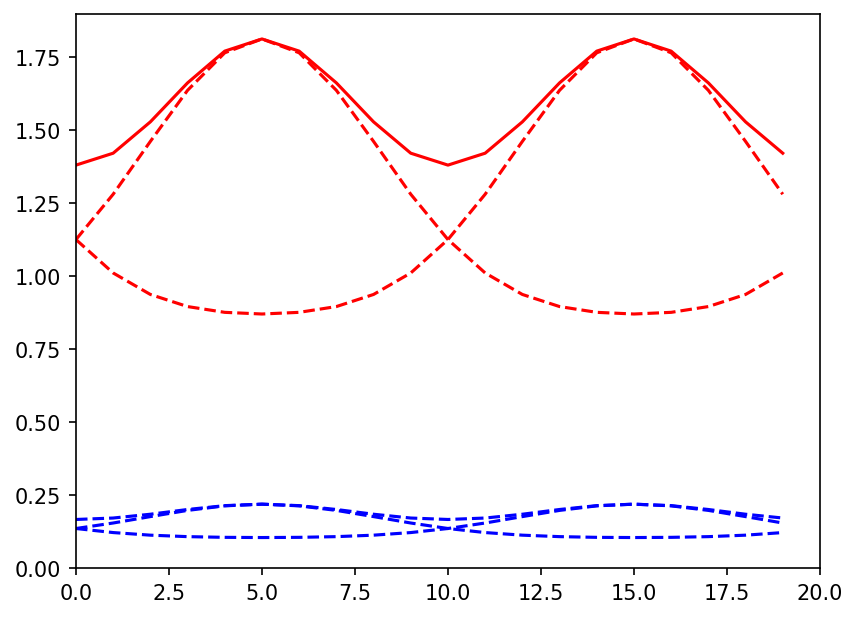

In [58]:
reload(su)

start = time.process_time()

net,M,H1,B,LAS,eps = su.gen_ring_disorder_tensor(0,this_prms,eX)
H2 = np.roll(H1,N//2)

print("Generating disorder took ",time.process_time() - start," s")
print('')

fig,ax = plt.subplots(1,1,dpi=150)

ax.plot(np.roll(bX*B+aXs[-1]*H1,N//4)[         ::net.NT],'r--')
ax.plot(np.roll(bX*B+aXs[-1]*H1,N//4)[net.NC[0]::net.NT],'b--')
ax.plot(np.roll(bX*B+aXs[-1]*H2,N//4)[         ::net.NT],'r--')
ax.plot(np.roll(bX*B+aXs[-1]*H2,N//4)[net.NC[0]::net.NT],'b--')
ax.plot(np.roll(bX*B+aXs[-1]*H1+aXs[-1]*H2,N//4)[        ::net.NT],'r-')
ax.plot(np.roll(bX*B+aXs[-1]*H1+aXs[-1]*H2,N//4)[net.NC[0]::net.NT],'b--')
ax.set_xlim(0,Nori)
ax.set_ylim(0,None)

In [5]:
reload(su)

start = time.process_time()

net,M,H1,B,LAS,eps = su.gen_ring_disorder_tensor(0,this_prms,eX)
H2 = np.roll(H1,N//2,0)

print("Generating disorder took ",time.process_time() - start," s")
print('')

# start = time.process_time()

# one_peak_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,(bX*B+aXs[-1]*H1)*eps,LAS,net.C_conds[0],mult_tau=True)
# one_peak_rates = torch.mean(one_peak_sol[:,mask_time],axis=1).cpu().numpy()
# one_peak_dynas = one_peak_sol[:,mask_time].cpu().numpy()

# np.save('one_peak_sol',one_peak_sol.cpu().numpy())

# print("Integrating one peak network took ",time.process_time() - start," s")
# print('')

# start = time.process_time()

# two_peak_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,(bX*B+aXs[-1]*(H1+H2))*eps,LAS,net.C_conds[0],mult_tau=True)
# two_peak_rates = torch.mean(two_peak_sol[:,mask_time],axis=1).cpu().numpy()
# two_peak_dynas = two_peak_sol[:,mask_time].cpu().numpy()

# np.save('two_peak_sol',two_peak_sol.cpu().numpy())

# print("Integrating two peak network took ",time.process_time() - start," s")
# print('')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
one_peak_sol = torch.from_numpy(np.load('one_peak_sol.npy')).to(device)
one_peak_rates = torch.mean(one_peak_sol[:,mask_time],axis=1).cpu().numpy()
one_peak_dynas = one_peak_sol[:,mask_time].cpu().numpy()
two_peak_sol = torch.from_numpy(np.load('two_peak_sol.npy')).to(device)
two_peak_rates = torch.mean(two_peak_sol[:,mask_time],axis=1).cpu().numpy()
two_peak_dynas = two_peak_sol[:,mask_time].cpu().numpy()

Using cpu
Generating disorder took  6.348163000000001  s



In [6]:
μrEs = np.zeros((2,Nori))
μrIs = np.zeros((2,Nori))

for nloc in range(Nori):
    μrEs[0,nloc] = np.mean(one_peak_rates[net.C_idxs[0][nloc]],axis=-1)
    μrIs[0,nloc] = np.mean(one_peak_rates[net.C_idxs[1][nloc]],axis=-1)
    μrEs[1,nloc] = np.mean(two_peak_rates[net.C_idxs[0][nloc]],axis=-1)
    μrIs[1,nloc] = np.mean(two_peak_rates[net.C_idxs[1][nloc]],axis=-1)

(0.0, 93.13151934593915)

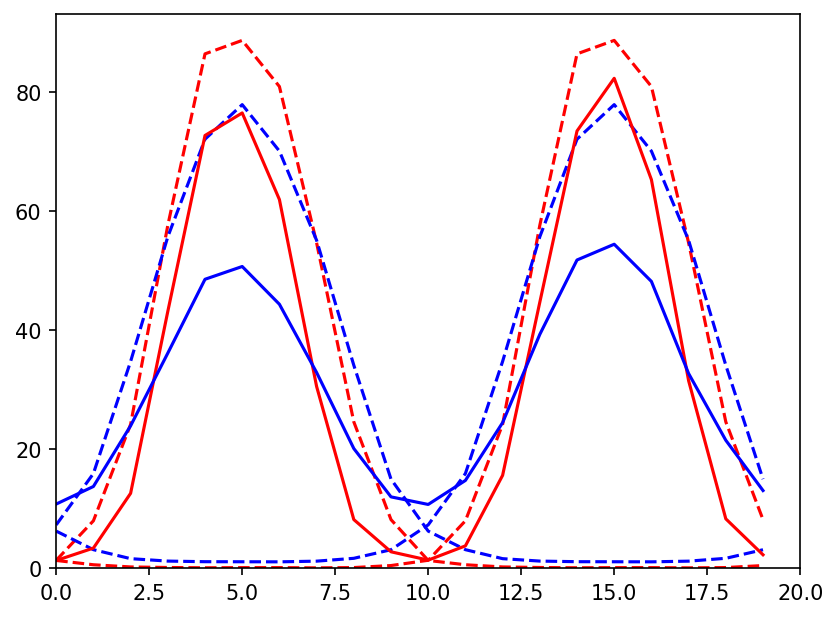

In [16]:
fig,ax = plt.subplots(1,1,dpi=150)

ax.plot(np.roll(μrEs[0],Nori//4),'r--')
ax.plot(np.roll(μrIs[0],Nori//4),'b--')
ax.plot(np.roll(μrEs[0],Nori*3//4),'r--')
ax.plot(np.roll(μrIs[0],Nori*3//4),'b--')
ax.plot(np.roll(μrEs[1],Nori//4),'r-')
ax.plot(np.roll(μrIs[1],Nori//4),'b-')
ax.set_xlim(0,Nori)
ax.set_ylim(0,None)

# Read Perturbation Tuning Simulation Results

In [23]:
tunes = np.arange(0,8+1)/8

sim_tune_μrEs = np.zeros((3,Nori,len(tunes),2))
sim_tune_μrIs = np.zeros((3,Nori,len(tunes),2))
sim_tune_ΣrEs = np.zeros((4,Nori,len(tunes),2))
sim_tune_ΣrIs = np.zeros((4,Nori,len(tunes),2))
sim_tune_vsm_base_means = np.zeros((len(tunes),2))
sim_tune_vsm_base_stds = np.zeros((len(tunes),2))
sim_tune_vsm_opto_means = np.zeros((len(tunes),2))
sim_tune_vsm_opto_stds = np.zeros((len(tunes),2))
sim_tune_vsm_diff_means = np.zeros((len(tunes),2))
sim_tune_vsm_diff_stds = np.zeros((len(tunes),2))
sim_tune_vsm_norm_covs = np.zeros((len(tunes),2))
sim_tune_Lexps = np.zeros((len(tunes),2,2))
sim_tune_timeouts = np.zeros((len(tunes),2,2))

for tune_idx,tune in enumerate(tunes):
    for ortho_idx,ortho in enumerate(np.arange(2)):
        try:
            with open('./../results/vary_id_None_tune_{:d}_ortho_{:d}'.format(tune_idx,ortho_idx)+'.pkl', 'rb') as\
                    handle:
                res_dict = pickle.load(handle)

            sim_tune_μrEs[:,:,tune_idx,ortho_idx] = np.mean(res_dict['μrEs'],0)
            sim_tune_μrIs[:,:,tune_idx,ortho_idx] = np.mean(res_dict['μrIs'],0)
            sim_tune_ΣrEs[:,:,tune_idx,ortho_idx] = np.mean(res_dict['ΣrEs'],0)
            sim_tune_ΣrIs[:,:,tune_idx,ortho_idx] = np.mean(res_dict['ΣrIs'],0)
            sim_tune_vsm_base_means[tune_idx,ortho_idx] = res_dict['vsm_base_means']
            sim_tune_vsm_base_stds[tune_idx,ortho_idx] = res_dict['vsm_base_stds']
            sim_tune_vsm_opto_means[tune_idx,ortho_idx] = res_dict['vsm_opto_means']
            sim_tune_vsm_opto_stds[tune_idx,ortho_idx] = res_dict['vsm_opto_stds']
            sim_tune_vsm_diff_means[tune_idx,ortho_idx] = res_dict['vsm_diff_means']
            sim_tune_vsm_diff_stds[tune_idx,ortho_idx] = res_dict['vsm_diff_stds']
            sim_tune_vsm_norm_covs[tune_idx,ortho_idx] = res_dict['vsm_norm_covs']
            sim_tune_Lexps[tune_idx,ortho_idx] = np.median(res_dict['Lexps'],-2)
            sim_tune_timeouts[tune_idx,ortho_idx] = np.sum(res_dict['timeouts'],-2)
            
        except:
            sim_tune_μrEs[:,:,tune_idx,ortho_idx] = np.nan
            sim_tune_μrIs[:,:,tune_idx,ortho_idx] = np.nan
            sim_tune_ΣrEs[:,:,tune_idx,ortho_idx] = np.nan
            sim_tune_ΣrIs[:,:,tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_base_means[tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_base_stds[tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_opto_means[tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_opto_stds[tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_diff_means[tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_diff_stds[tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_norm_covs[tune_idx,ortho_idx] = np.nan
            sim_tune_Lexps[tune_idx,ortho_idx] = np.nan
            sim_tune_timeouts[tune_idx,ortho_idx] = 0

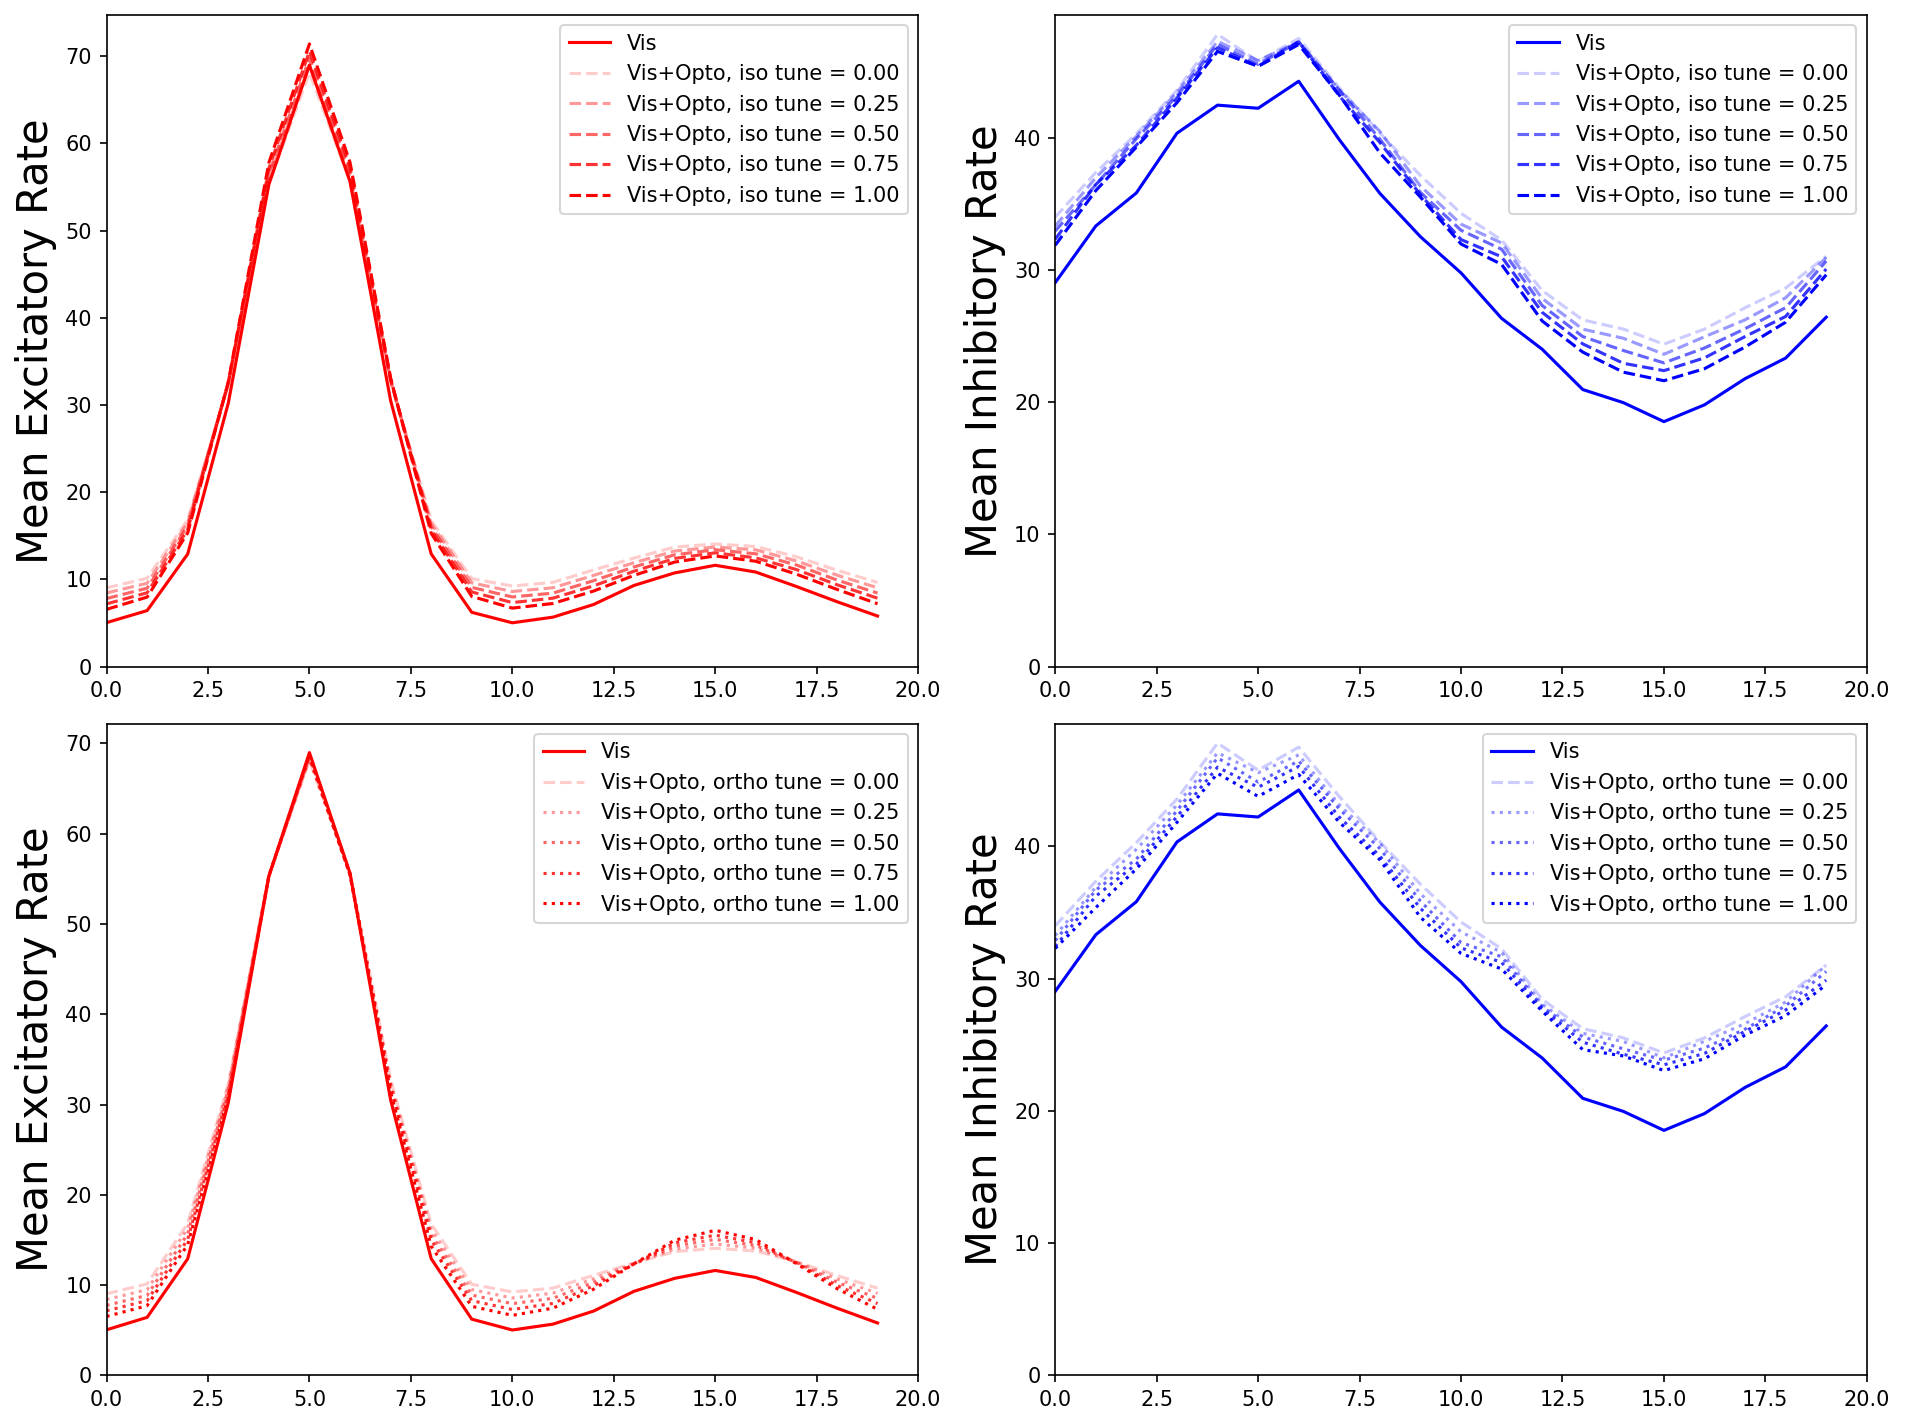

In [24]:
fig,axs = plt.subplots(2,2,figsize=(2*6.4,2*4.8),dpi=150)

axs[0,0].plot(np.roll(sim_tune_μrEs[0,:,0,0],Nori//4),'r',label='Vis')
axs[0,1].plot(np.roll(sim_tune_μrIs[0,:,0,0],Nori//4),'b',label='Vis')
axs[1,0].plot(np.roll(sim_tune_μrEs[0,:,0,0],Nori//4),'r',label='Vis')
axs[1,1].plot(np.roll(sim_tune_μrIs[0,:,0,0],Nori//4),'b',label='Vis')
for tune_idx,tune in enumerate(tunes[::2]):
    axs[0,0].plot(np.roll(sim_tune_μrEs[1,:,tune_idx,0],Nori//4),'r--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, iso tune = {:.2f}'.format(tune))
    axs[0,1].plot(np.roll(sim_tune_μrIs[1,:,tune_idx,0],Nori//4),'b--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, iso tune = {:.2f}'.format(tune))
    if tune_idx == 0:
        axs[1,0].plot(np.roll(sim_tune_μrEs[1,:,tune_idx,0],Nori//4),'r--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, ortho tune = {:.2f}'.format(tune))
        axs[1,1].plot(np.roll(sim_tune_μrIs[1,:,tune_idx,0],Nori//4),'b--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, ortho tune = {:.2f}'.format(tune))
    else:
        axs[1,0].plot(np.roll(sim_tune_μrEs[1,:,tune_idx,1],Nori//4),'r:',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, ortho tune = {:.2f}'.format(tune))
        axs[1,1].plot(np.roll(sim_tune_μrIs[1,:,tune_idx,1],Nori//4),'b:',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, ortho tune = {:.2f}'.format(tune))
for i in range(2):
    axs[0,i].set_xlim(0,Nori)
    axs[0,i].set_ylim(0,None)
    axs[0,i].legend()
    axs[0,i].set_ylabel('Mean {:s} Rate'.format(['Excitatory','Inhibitory'][i]),fontsize=20)
    axs[1,i].set_xlim(0,Nori)
    axs[1,i].set_ylim(0,None)
    axs[1,i].legend()
    axs[1,i].set_ylabel('Mean {:s} Rate'.format(['Excitatory','Inhibitory'][i]),fontsize=20)
    
fig.tight_layout()
fig.savefig('./../plots/tune_opto_resp.pdf')

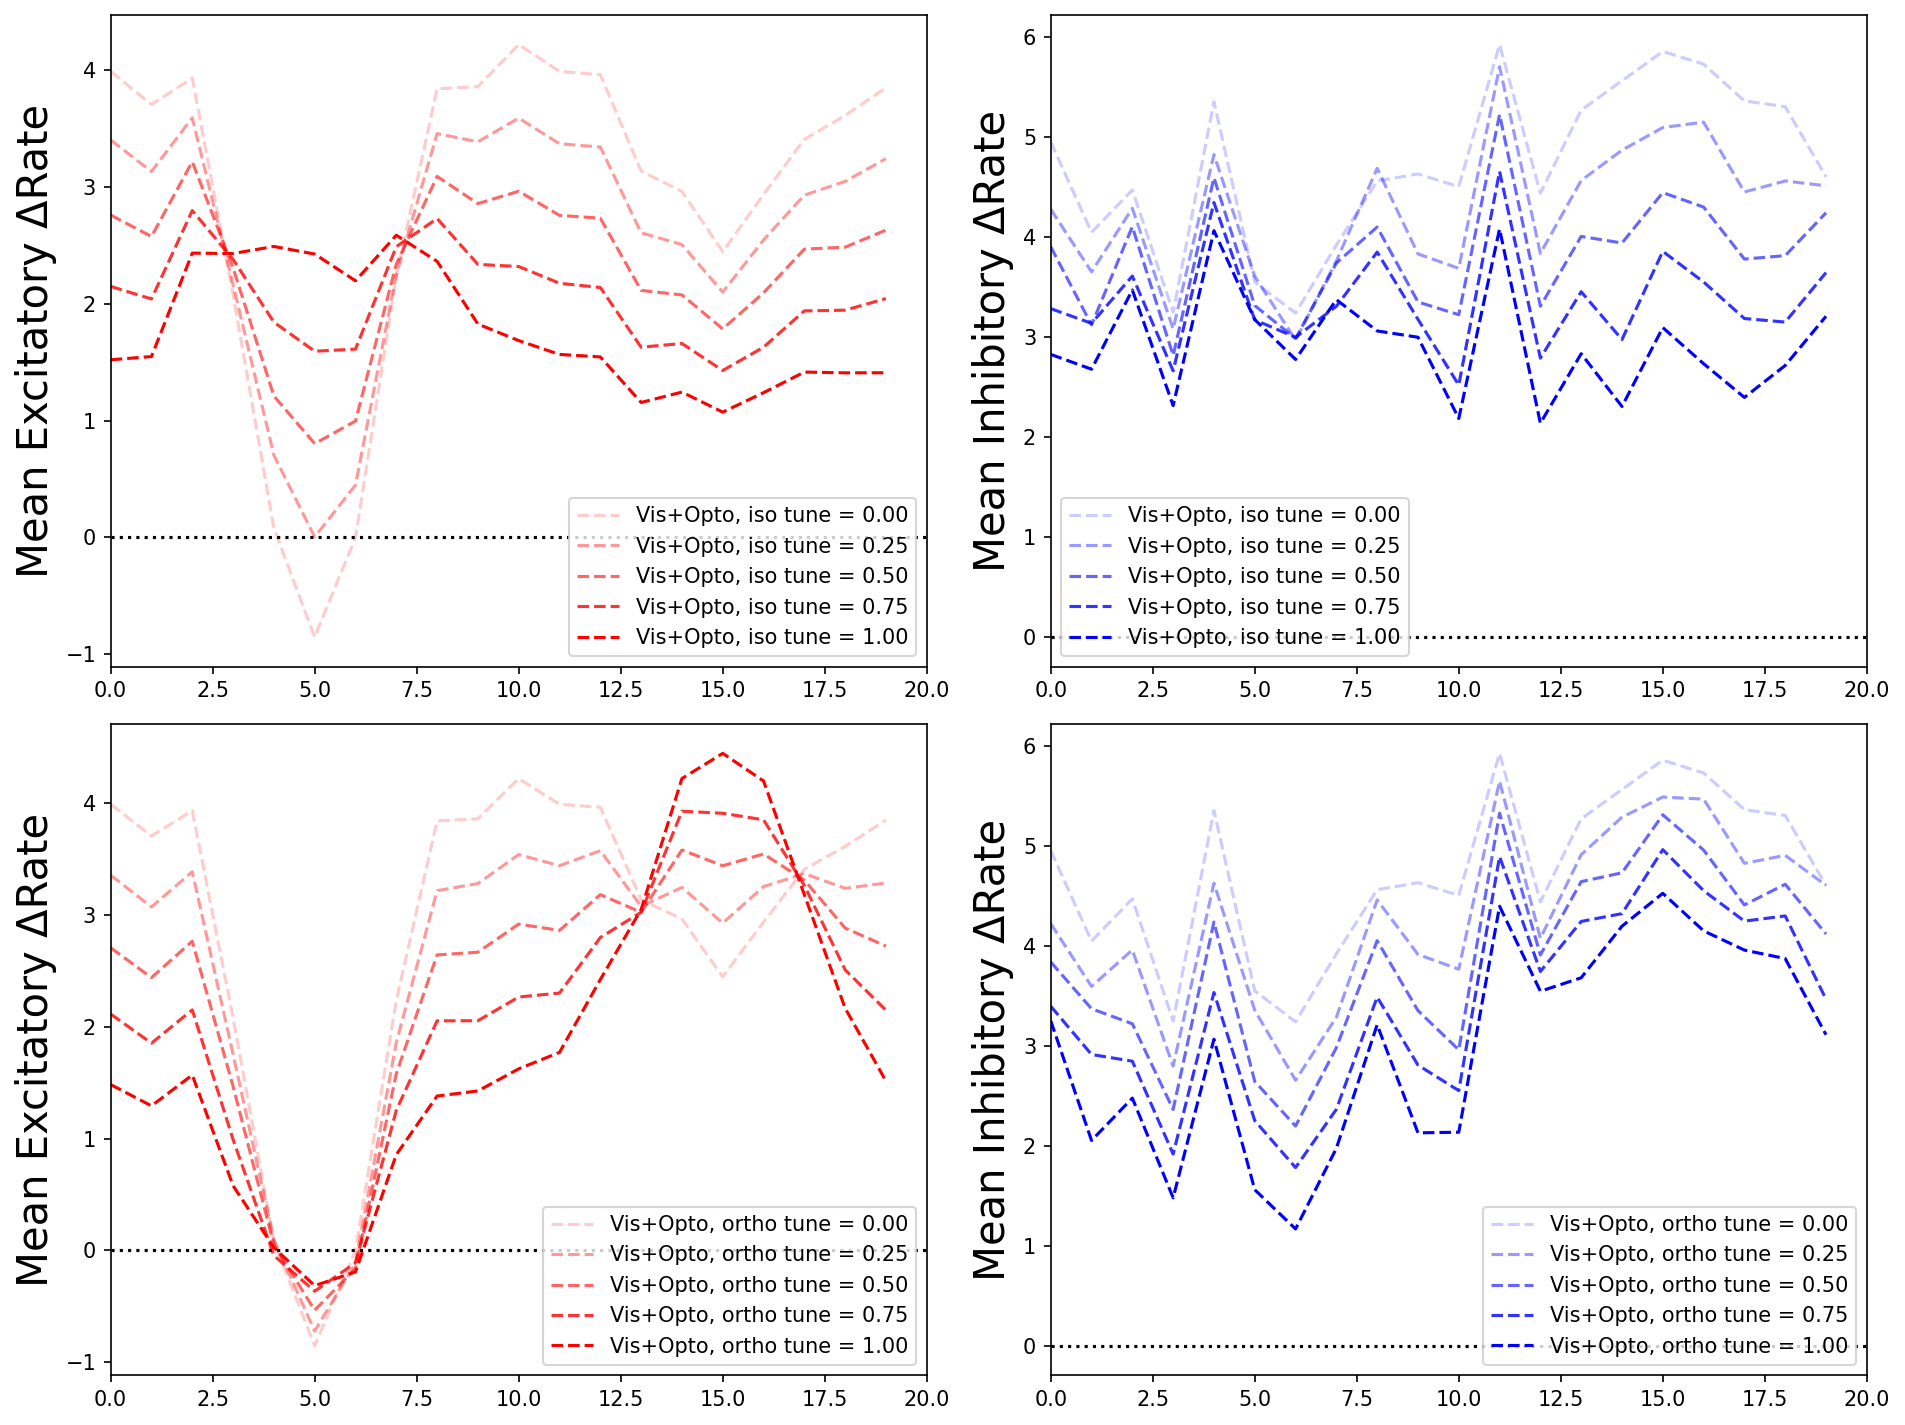

In [25]:
fig,axs = plt.subplots(2,2,figsize=(2*6.4,2*4.8),dpi=150)

for tune_idx,tune in enumerate(tunes[::2]):
    axs[0,0].plot(np.roll(sim_tune_μrEs[1,:,tune_idx,0]-sim_tune_μrEs[0,:,0,0],Nori//4),'r--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, iso tune = {:.2f}'.format(tune))
    axs[0,1].plot(np.roll(sim_tune_μrIs[1,:,tune_idx,0]-sim_tune_μrIs[0,:,0,0],Nori//4),'b--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, iso tune = {:.2f}'.format(tune))
    if tune_idx == 0:
        axs[1,0].plot(np.roll(sim_tune_μrEs[1,:,tune_idx,0]-sim_tune_μrEs[0,:,0,0],Nori//4),'r--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, ortho tune = {:.2f}'.format(tune))
        axs[1,1].plot(np.roll(sim_tune_μrIs[1,:,tune_idx,0]-sim_tune_μrIs[0,:,0,0],Nori//4),'b--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, ortho tune = {:.2f}'.format(tune))
    else:
        axs[1,0].plot(np.roll(sim_tune_μrEs[1,:,tune_idx,1]-sim_tune_μrEs[0,:,0,0],Nori//4),'r--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, ortho tune = {:.2f}'.format(tune))
        axs[1,1].plot(np.roll(sim_tune_μrIs[1,:,tune_idx,1]-sim_tune_μrIs[0,:,0,0],Nori//4),'b--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, ortho tune = {:.2f}'.format(tune))
for i in range(2):
    axs[0,i].set_xlim(0,Nori)
    axs[0,i].axhline(0,c='k',ls=':')
    axs[0,i].legend()
    axs[0,i].set_ylabel('Mean {:s} ΔRate'.format(['Excitatory','Inhibitory'][i]),fontsize=20)
    axs[1,i].set_xlim(0,Nori)
    axs[1,i].axhline(0,c='k',ls=':')
    axs[1,i].legend()
    axs[1,i].set_ylabel('Mean {:s} ΔRate'.format(['Excitatory','Inhibitory'][i]),fontsize=20)
    
fig.tight_layout()
fig.savefig('./../plots/tune_opto_diff_resp.pdf')

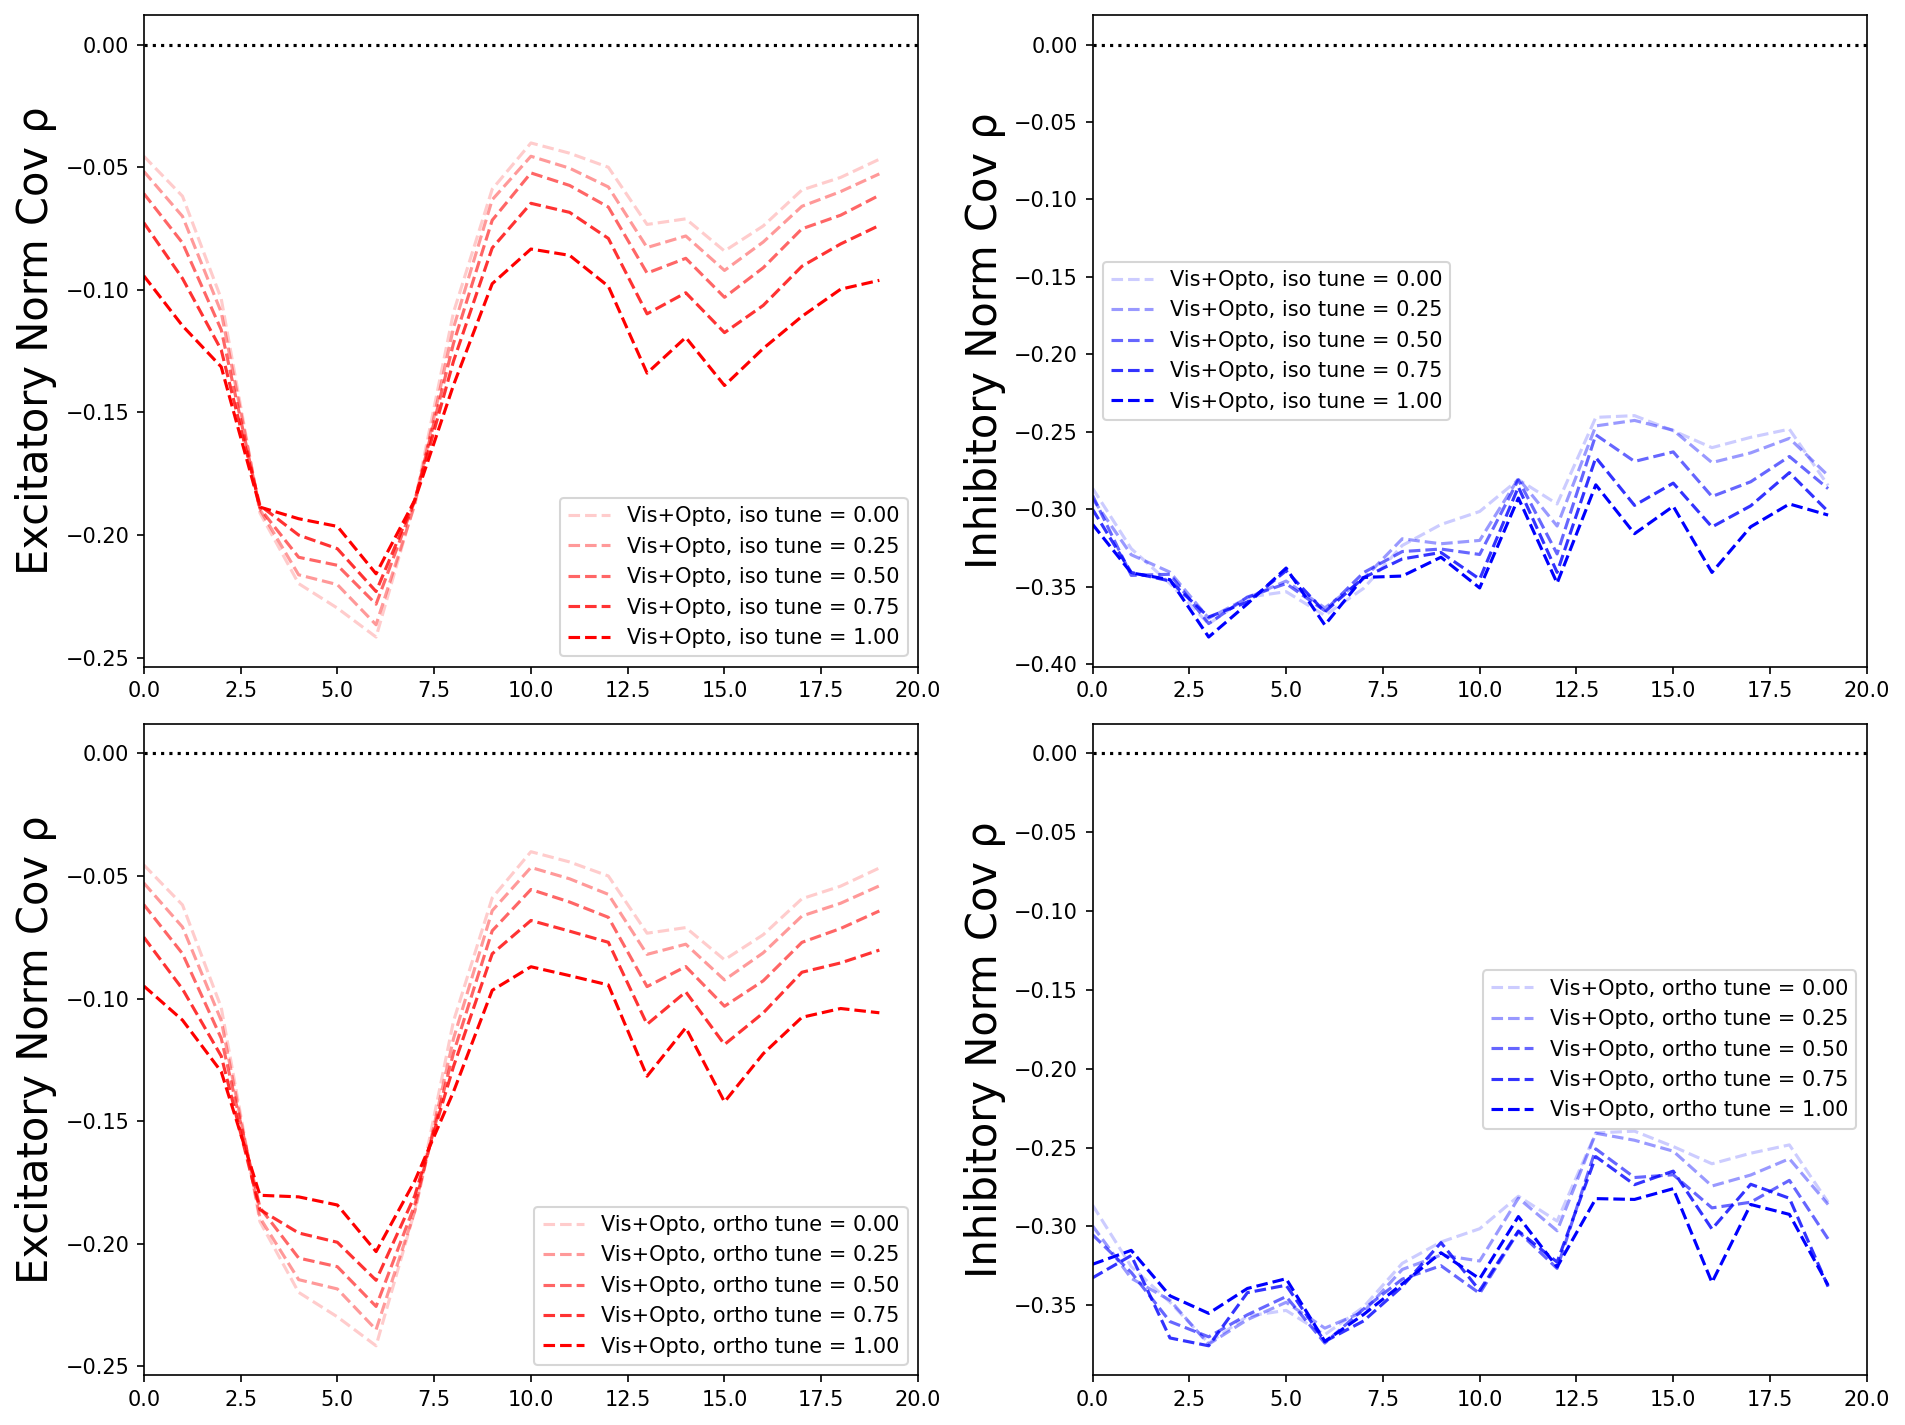

In [27]:
fig,axs = plt.subplots(2,2,figsize=(2*6.4,2*4.8),dpi=150)

for tune_idx,tune in enumerate(tunes[::2]):
    axs[0,0].plot(np.roll(sim_tune_ΣrEs[3,:,tune_idx,0]/sim_tune_ΣrEs[2,:,tune_idx,0],Nori//4),'r--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, iso tune = {:.2f}'.format(tune))
    axs[0,1].plot(np.roll(sim_tune_ΣrIs[3,:,tune_idx,0]/sim_tune_ΣrIs[2,:,tune_idx,0],Nori//4),'b--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, iso tune = {:.2f}'.format(tune))
    if tune_idx == 0:
        axs[1,0].plot(np.roll(sim_tune_ΣrEs[3,:,tune_idx,0]/sim_tune_ΣrEs[2,:,tune_idx,0],Nori//4),'r--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, ortho tune = {:.2f}'.format(tune))
        axs[1,1].plot(np.roll(sim_tune_ΣrIs[3,:,tune_idx,0]/sim_tune_ΣrIs[2,:,tune_idx,0],Nori//4),'b--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, ortho tune = {:.2f}'.format(tune))
    else:
        axs[1,0].plot(np.roll(sim_tune_ΣrEs[3,:,tune_idx,1]/sim_tune_ΣrEs[2,:,tune_idx,0],Nori//4),'r--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, ortho tune = {:.2f}'.format(tune))
        axs[1,1].plot(np.roll(sim_tune_ΣrIs[3,:,tune_idx,1]/sim_tune_ΣrIs[2,:,tune_idx,0],Nori//4),'b--',alpha=(tune_idx+1)/len(tunes[::2]),label='Vis+Opto, ortho tune = {:.2f}'.format(tune))
for i in range(2):
    axs[0,i].set_xlim(0,Nori)
    axs[0,i].axhline(0,c='k',ls=':')
    axs[0,i].legend()
    axs[0,i].set_ylabel('{:s} Norm Cov ρ'.format(['Excitatory','Inhibitory'][i]),fontsize=20)
    axs[1,i].set_xlim(0,Nori)
    axs[1,i].axhline(0,c='k',ls=':')
    axs[1,i].legend()
    axs[1,i].set_ylabel('{:s} Norm Cov ρ'.format(['Excitatory','Inhibitory'][i]),fontsize=20)
    
fig.tight_layout()
fig.savefig('./../plots/tune_opto_norm_cov.pdf')

# Read Normalization Simulation Results

In [82]:
bases = 2*np.arange(4+1)/4
cons = aXs

sim_norm_μrEs = np.zeros((Nori,len(bases),len(cons),len(cons)))
sim_norm_μrIs = np.zeros((Nori,len(bases),len(cons),len(cons)))
sim_norm_ΣrEs = np.zeros((Nori,len(bases),len(cons),len(cons)))
sim_norm_ΣrIs = np.zeros((Nori,len(bases),len(cons),len(cons)))
sim_norm_vsm1_base_means = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_vsm1_base_stds = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_vsm2_base_means = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_vsm2_base_stds = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_Lexps = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_timeouts = np.zeros((len(bases),len(cons),len(cons)))

for base_idx,base in enumerate(bases):
    for con1_idx,con1 in enumerate(cons):
        for con2_idx,con2 in enumerate(cons):
            if con2_idx > con1_idx: continue
            
            try:
                with open('./../results/vary_id_None_base_{:.1f}_c1_{:d}_c2_{:d}'.format(base,con1_idx,con2_idx)+'.pkl', 'rb') as\
                        handle:
                    res_dict = pickle.load(handle)

                sim_norm_μrEs[:,base_idx,con1_idx,con2_idx] = np.mean(res_dict['μrEs'],0)
                sim_norm_μrIs[:,base_idx,con1_idx,con2_idx] = np.mean(res_dict['μrIs'],0)
                sim_norm_ΣrEs[:,base_idx,con1_idx,con2_idx] = np.mean(res_dict['ΣrEs'],0)
                sim_norm_ΣrIs[:,base_idx,con1_idx,con2_idx] = np.mean(res_dict['ΣrIs'],0)
                sim_norm_vsm1_base_means[base_idx,con1_idx,con2_idx] = res_dict['vsm1_base_means']
                sim_norm_vsm1_base_stds[base_idx,con1_idx,con2_idx] = res_dict['vsm1_base_stds']
                sim_norm_vsm2_base_means[base_idx,con1_idx,con2_idx] = res_dict['vsm2_base_means']
                sim_norm_vsm2_base_stds[base_idx,con1_idx,con2_idx] = res_dict['vsm2_base_stds']
                sim_norm_Lexps[base_idx,con1_idx,con2_idx] = np.median(res_dict['Lexps'])
                sim_norm_timeouts[base_idx,con1_idx,con2_idx] = np.sum(res_dict['timeouts'])
                
            except:
                sim_norm_μrEs[:,base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_μrIs[:,base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_ΣrEs[:,base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_ΣrIs[:,base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_vsm1_base_means[base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_vsm1_base_stds[base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_vsm2_base_means[base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_vsm2_base_stds[base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_Lexps[base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_timeouts[base_idx,con1_idx,con2_idx] = 0

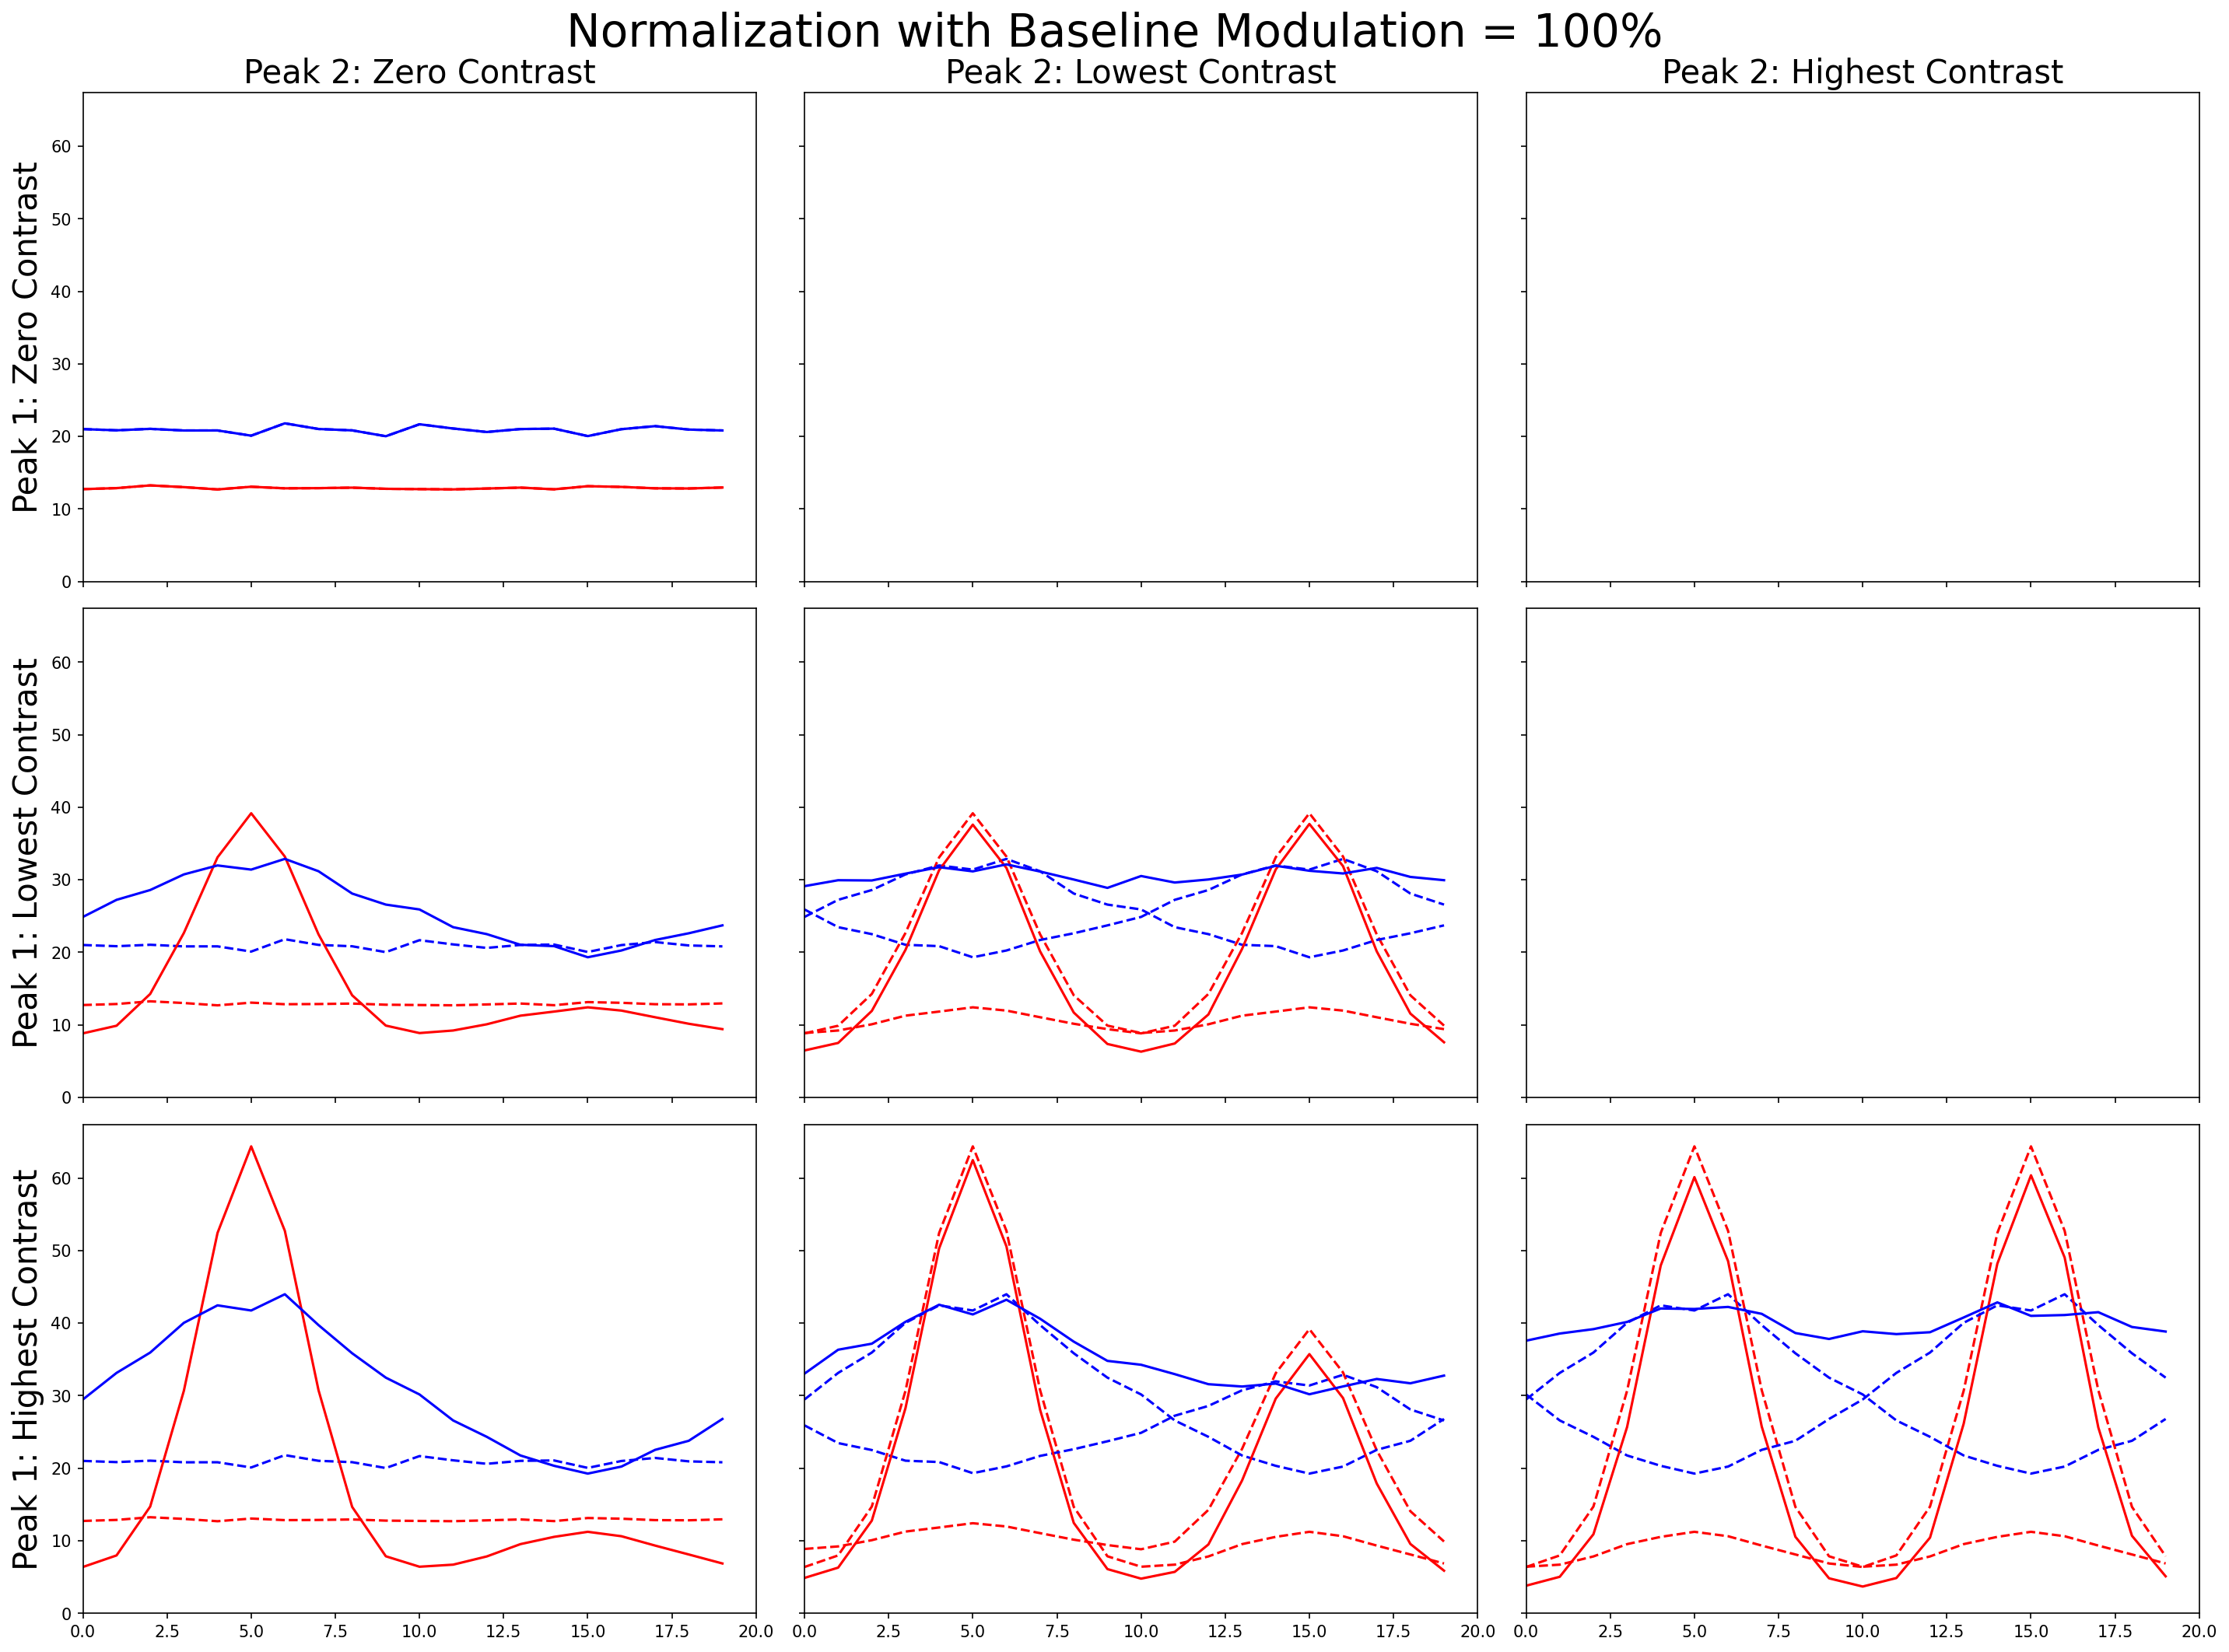

In [9]:
fig,axs = plt.subplots(3,3,figsize=(3*6.4,3*4.8),dpi=150,sharex=True,sharey=True)

b_idx = 2

for con1_idx,con1 in enumerate(cons[[0,1,-1]]):
    for con2_idx,con2 in enumerate(cons[[0,1,-1]]):
        if con2_idx > con1_idx: continue
        if con2_idx == 0:
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[:,b_idx,[0,1,-1][con2_idx],0],Nori//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[:,b_idx,[0,1,-1][con2_idx],0],Nori//4),'b--')
        else:
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[:,b_idx,[0,1,-1][con1_idx],0],Nori//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[:,b_idx,[0,1,-1][con2_idx],0],Nori*3//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[:,b_idx,[0,1,-1][con1_idx],0],Nori//4),'b--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[:,b_idx,[0,1,-1][con2_idx],0],Nori*3//4),'b--')
        axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[:,b_idx,[0,1,-1][con1_idx],[0,1,-1][con2_idx]],Nori//4),'r-')
        axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[:,b_idx,[0,1,-1][con1_idx],[0,1,-1][con2_idx]],Nori//4),'b-')
        
axs[0,0].set_xlim(0,Nori)
axs[0,0].set_ylim(0,None)
axs[0,0].set_ylabel('Peak 1: Zero Contrast',fontsize=20)
axs[1,0].set_ylabel('Peak 1: Lowest Contrast',fontsize=20)
axs[-1,0].set_ylabel('Peak 1: Highest Contrast',fontsize=20)
axs[0,0].set_title('Peak 2: Zero Contrast',fontsize=20)
axs[0,1].set_title('Peak 2: Lowest Contrast',fontsize=20)
axs[0,-1].set_title('Peak 2: Highest Contrast',fontsize=20)
fig.suptitle('Normalization with Baseline Modulation = {:d}%'.format(int(100*bases[b_idx])),fontsize=28)
fig.tight_layout()

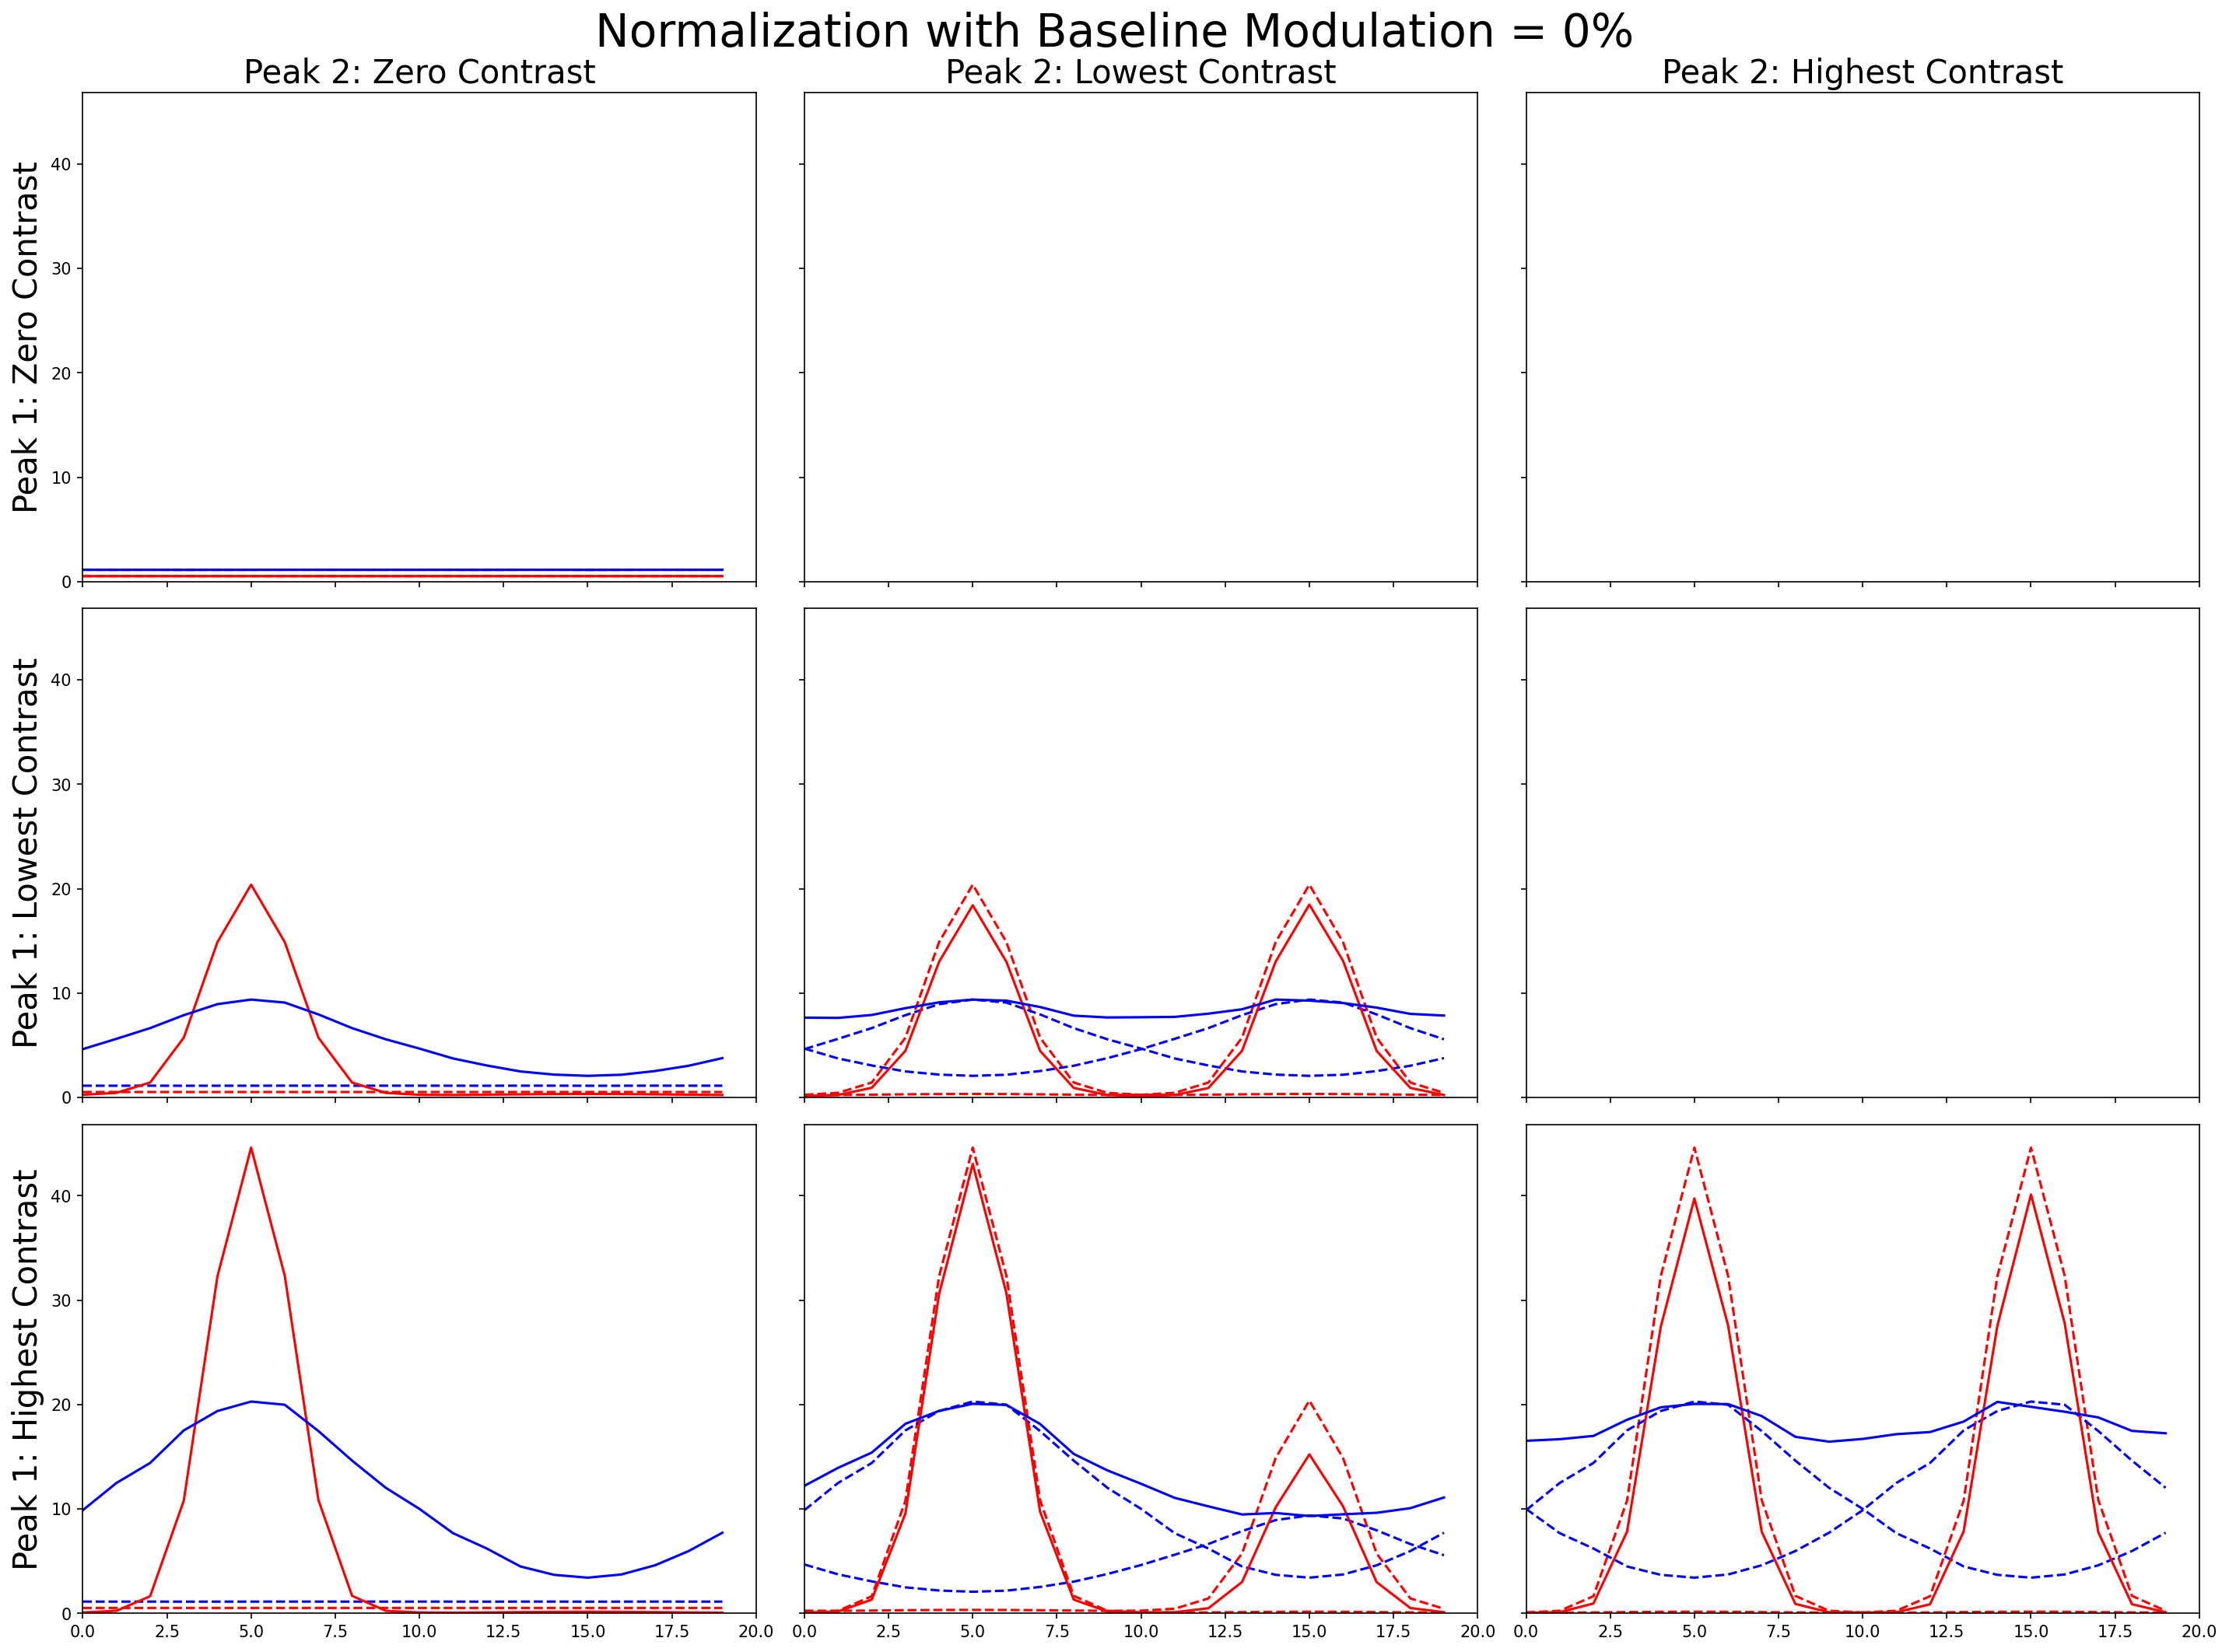

In [10]:
fig,axs = plt.subplots(3,3,figsize=(3*6.4,3*4.8),dpi=150,sharex=True,sharey=True)

b_idx = 0

for con1_idx,con1 in enumerate(cons[[0,1,-1]]):
    for con2_idx,con2 in enumerate(cons[[0,1,-1]]):
        if con2_idx > con1_idx: continue
        if con2_idx == 0:
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[:,b_idx,[0,1,-1][con2_idx],0],Nori//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[:,b_idx,[0,1,-1][con2_idx],0],Nori//4),'b--')
        else:
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[:,b_idx,[0,1,-1][con1_idx],0],Nori//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[:,b_idx,[0,1,-1][con2_idx],0],Nori*3//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[:,b_idx,[0,1,-1][con1_idx],0],Nori//4),'b--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[:,b_idx,[0,1,-1][con2_idx],0],Nori*3//4),'b--')
        axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[:,b_idx,[0,1,-1][con1_idx],[0,1,-1][con2_idx]],Nori//4),'r-')
        axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[:,b_idx,[0,1,-1][con1_idx],[0,1,-1][con2_idx]],Nori//4),'b-')
        
axs[0,0].set_xlim(0,Nori)
axs[0,0].set_ylim(0,None)
axs[0,0].set_ylabel('Peak 1: Zero Contrast',fontsize=20)
axs[1,0].set_ylabel('Peak 1: Lowest Contrast',fontsize=20)
axs[-1,0].set_ylabel('Peak 1: Highest Contrast',fontsize=20)
axs[0,0].set_title('Peak 2: Zero Contrast',fontsize=20)
axs[0,1].set_title('Peak 2: Lowest Contrast',fontsize=20)
axs[0,-1].set_title('Peak 2: Highest Contrast',fontsize=20)
fig.suptitle('Normalization with Baseline Modulation = {:d}%'.format(int(100*bases[b_idx])),fontsize=28)
fig.tight_layout()

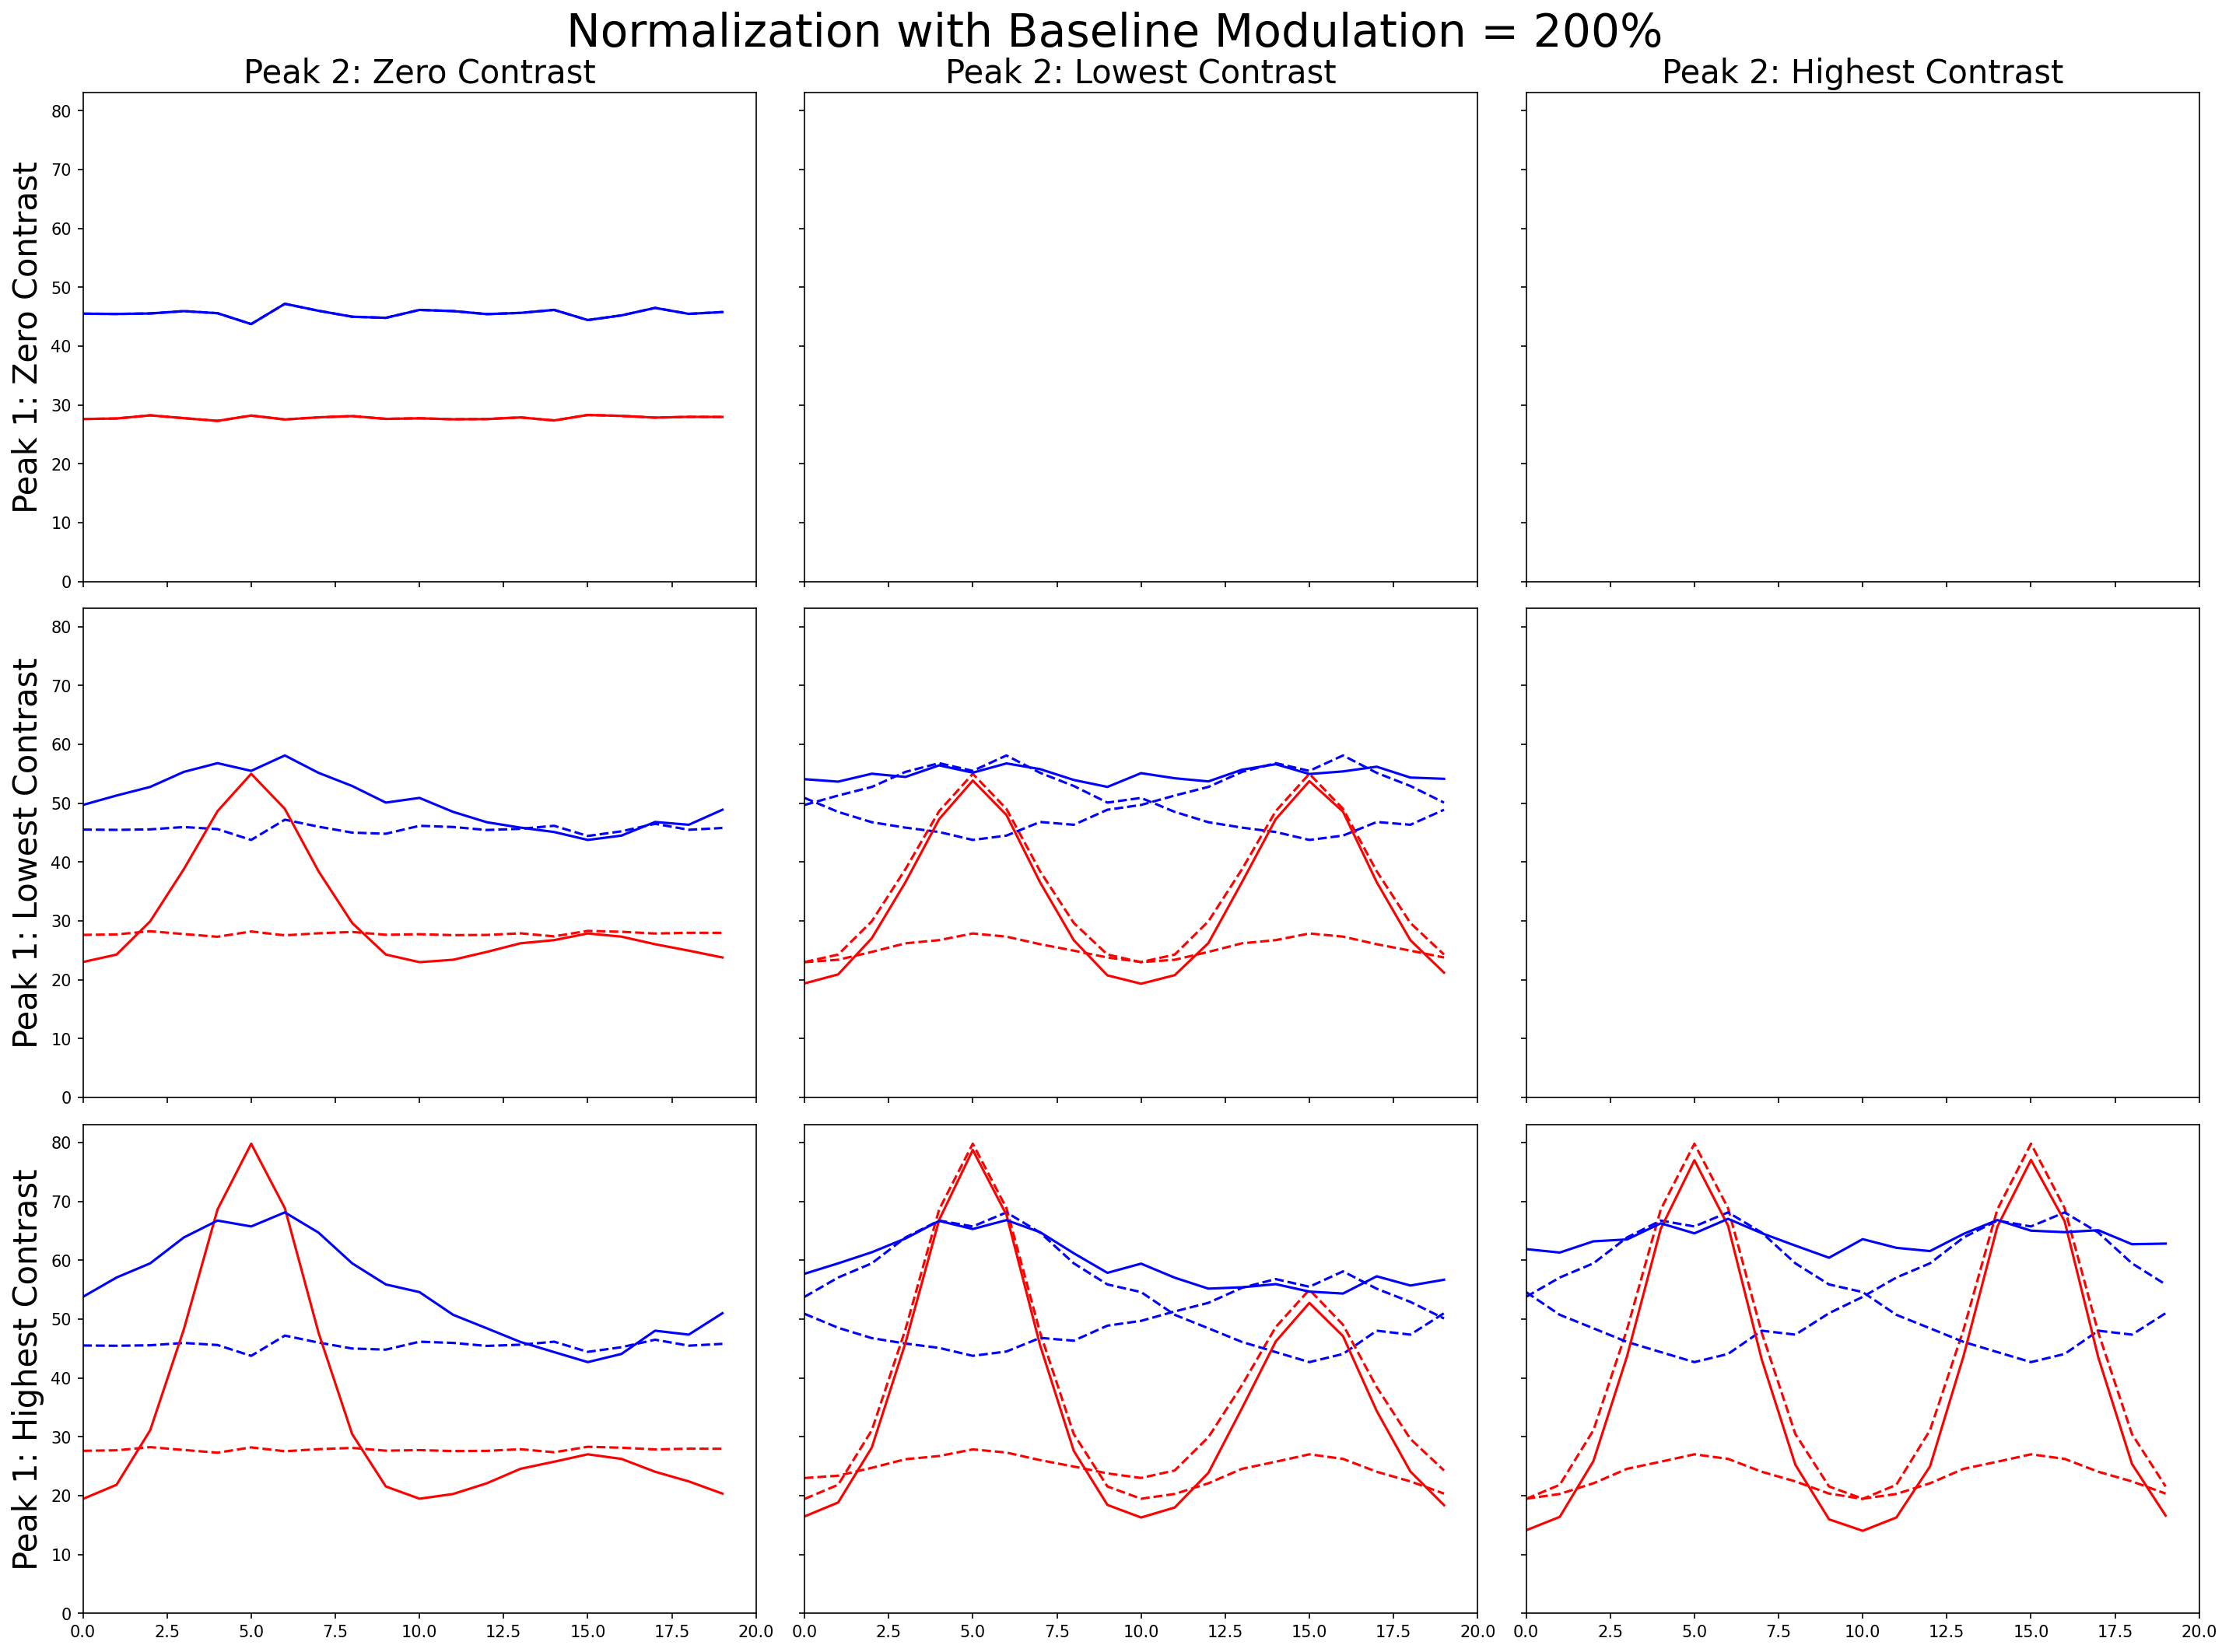

In [11]:
fig,axs = plt.subplots(3,3,figsize=(3*6.4,3*4.8),dpi=150,sharex=True,sharey=True)

b_idx = 4

for con1_idx,con1 in enumerate(cons[[0,1,-1]]):
    for con2_idx,con2 in enumerate(cons[[0,1,-1]]):
        if con2_idx > con1_idx: continue
        if con2_idx == 0:
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[:,b_idx,[0,1,-1][con2_idx],0],Nori//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[:,b_idx,[0,1,-1][con2_idx],0],Nori//4),'b--')
        else:
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[:,b_idx,[0,1,-1][con1_idx],0],Nori//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[:,b_idx,[0,1,-1][con2_idx],0],Nori*3//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[:,b_idx,[0,1,-1][con1_idx],0],Nori//4),'b--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[:,b_idx,[0,1,-1][con2_idx],0],Nori*3//4),'b--')
        axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[:,b_idx,[0,1,-1][con1_idx],[0,1,-1][con2_idx]],Nori//4),'r-')
        axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[:,b_idx,[0,1,-1][con1_idx],[0,1,-1][con2_idx]],Nori//4),'b-')
        
axs[0,0].set_xlim(0,Nori)
axs[0,0].set_ylim(0,None)
axs[0,0].set_ylabel('Peak 1: Zero Contrast',fontsize=20)
axs[1,0].set_ylabel('Peak 1: Lowest Contrast',fontsize=20)
axs[-1,0].set_ylabel('Peak 1: Highest Contrast',fontsize=20)
axs[0,0].set_title('Peak 2: Zero Contrast',fontsize=20)
axs[0,1].set_title('Peak 2: Lowest Contrast',fontsize=20)
axs[0,-1].set_title('Peak 2: Highest Contrast',fontsize=20)
fig.suptitle('Normalization with Baseline Modulation = {:d}%'.format(int(100*bases[b_idx])),fontsize=28)
fig.tight_layout()

Text(0, 0.5, 'Baseline-Subtracted Normalization Weight')

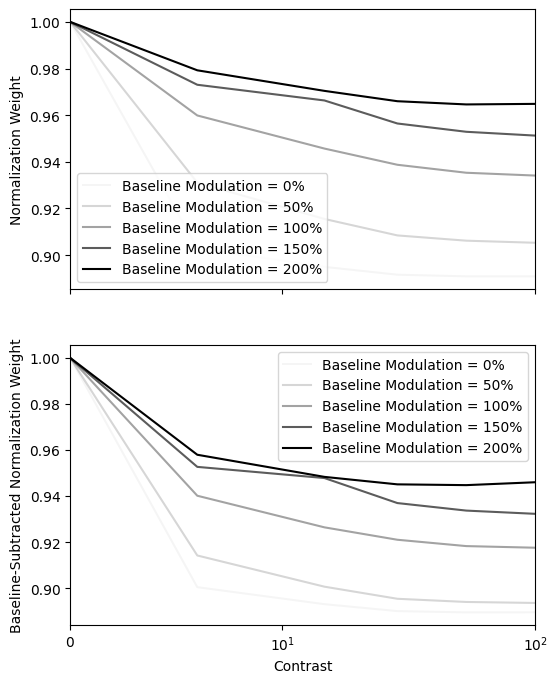

In [83]:
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]
    
fig,axs = plt.subplots(2,1,figsize=(6,8),sharex=True)

for i,base in enumerate(bases):
    axs[0].plot(cons,np.diag(sim_norm_μrEs[0,i,:,:])/sim_norm_μrEs[0,i,:,0],'k',alpha=((i+1)/len(bases))**2,
                label='Baseline Modulation = {:.0f}%'.format(100*base))
    axs[1].plot(cons,(np.diag(sim_norm_μrEs[0,i,:,:])-np.mean(sim_norm_μrEs[:,i,0,0]))/(sim_norm_μrEs[0,i,:,0]-np.mean(sim_norm_μrEs[:,i,0,0])),'k',alpha=((i+1)/len(bases))**2,
                label='Baseline Modulation = {:.0f}%'.format(100*base))
axs[0].legend()
axs[1].legend()
axs[0].set_xscale('symlog',linthresh=12)
axs[0].set_xlim(0,100)
axs[1].set_xlabel('Contrast')
axs[0].set_ylabel('Normalization Weight')
axs[1].set_ylabel('Baseline-Subtracted Normalization Weight')

# Plot Normalization under Opto Stim Results

In [15]:
bases = (2*np.arange(4+1)/4)[2:3]
cons = aXs

sim_norm_μrEs = np.zeros((3,Nori,len(bases),len(cons),len(cons)))
sim_norm_μrIs = np.zeros((3,Nori,len(bases),len(cons),len(cons)))
sim_norm_ΣrEs = np.zeros((4,Nori,len(bases),len(cons),len(cons)))
sim_norm_ΣrIs = np.zeros((4,Nori,len(bases),len(cons),len(cons)))
sim_norm_vsm1_base_means = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_vsm1_base_stds = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_vsm1_opto_means = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_vsm1_opto_stds = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_vsm2_base_means = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_vsm2_base_stds = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_vsm2_opto_means = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_vsm2_opto_stds = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_Lexps = np.zeros((len(bases),len(cons),len(cons)))
sim_norm_timeouts = np.zeros((len(bases),len(cons),len(cons)))

for base_idx,base in enumerate(bases):
    for con1_idx,con1 in enumerate(cons):
        for con2_idx,con2 in enumerate(cons):
            if con2_idx > con1_idx: continue
            
            try:
                with open('./../results/opto_norm_id_None_base_{:.1f}_c1_{:d}_c2_{:d}'.format(base,con1_idx,con2_idx)+'.pkl', 'rb') as\
                        handle:
                    res_dict = pickle.load(handle)

                sim_norm_μrEs[:,:,base_idx,con1_idx,con2_idx] = np.mean(res_dict['μrEs'],0)
                sim_norm_μrIs[:,:,base_idx,con1_idx,con2_idx] = np.mean(res_dict['μrIs'],0)
                sim_norm_ΣrEs[:,:,base_idx,con1_idx,con2_idx] = np.mean(res_dict['ΣrEs'],0)
                sim_norm_ΣrIs[:,:,base_idx,con1_idx,con2_idx] = np.mean(res_dict['ΣrIs'],0)
                sim_norm_vsm1_base_means[base_idx,con1_idx,con2_idx] = res_dict['vsm1_base_means']
                sim_norm_vsm1_base_stds[base_idx,con1_idx,con2_idx] = res_dict['vsm1_base_stds']
                sim_norm_vsm2_base_means[base_idx,con1_idx,con2_idx] = res_dict['vsm2_base_means']
                sim_norm_vsm2_base_stds[base_idx,con1_idx,con2_idx] = res_dict['vsm2_base_stds']
                sim_norm_Lexps[base_idx,con1_idx,con2_idx] = np.median(res_dict['Lexps'])
                sim_norm_timeouts[base_idx,con1_idx,con2_idx] = np.sum(res_dict['timeouts'])
                
            except:
                sim_norm_μrEs[:,:,base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_μrIs[:,:,base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_ΣrEs[:,:,base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_ΣrIs[:,:,base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_vsm1_base_means[base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_vsm1_base_stds[base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_vsm2_base_means[base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_vsm2_base_stds[base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_Lexps[base_idx,con1_idx,con2_idx] = np.nan
                sim_norm_timeouts[base_idx,con1_idx,con2_idx] = 0

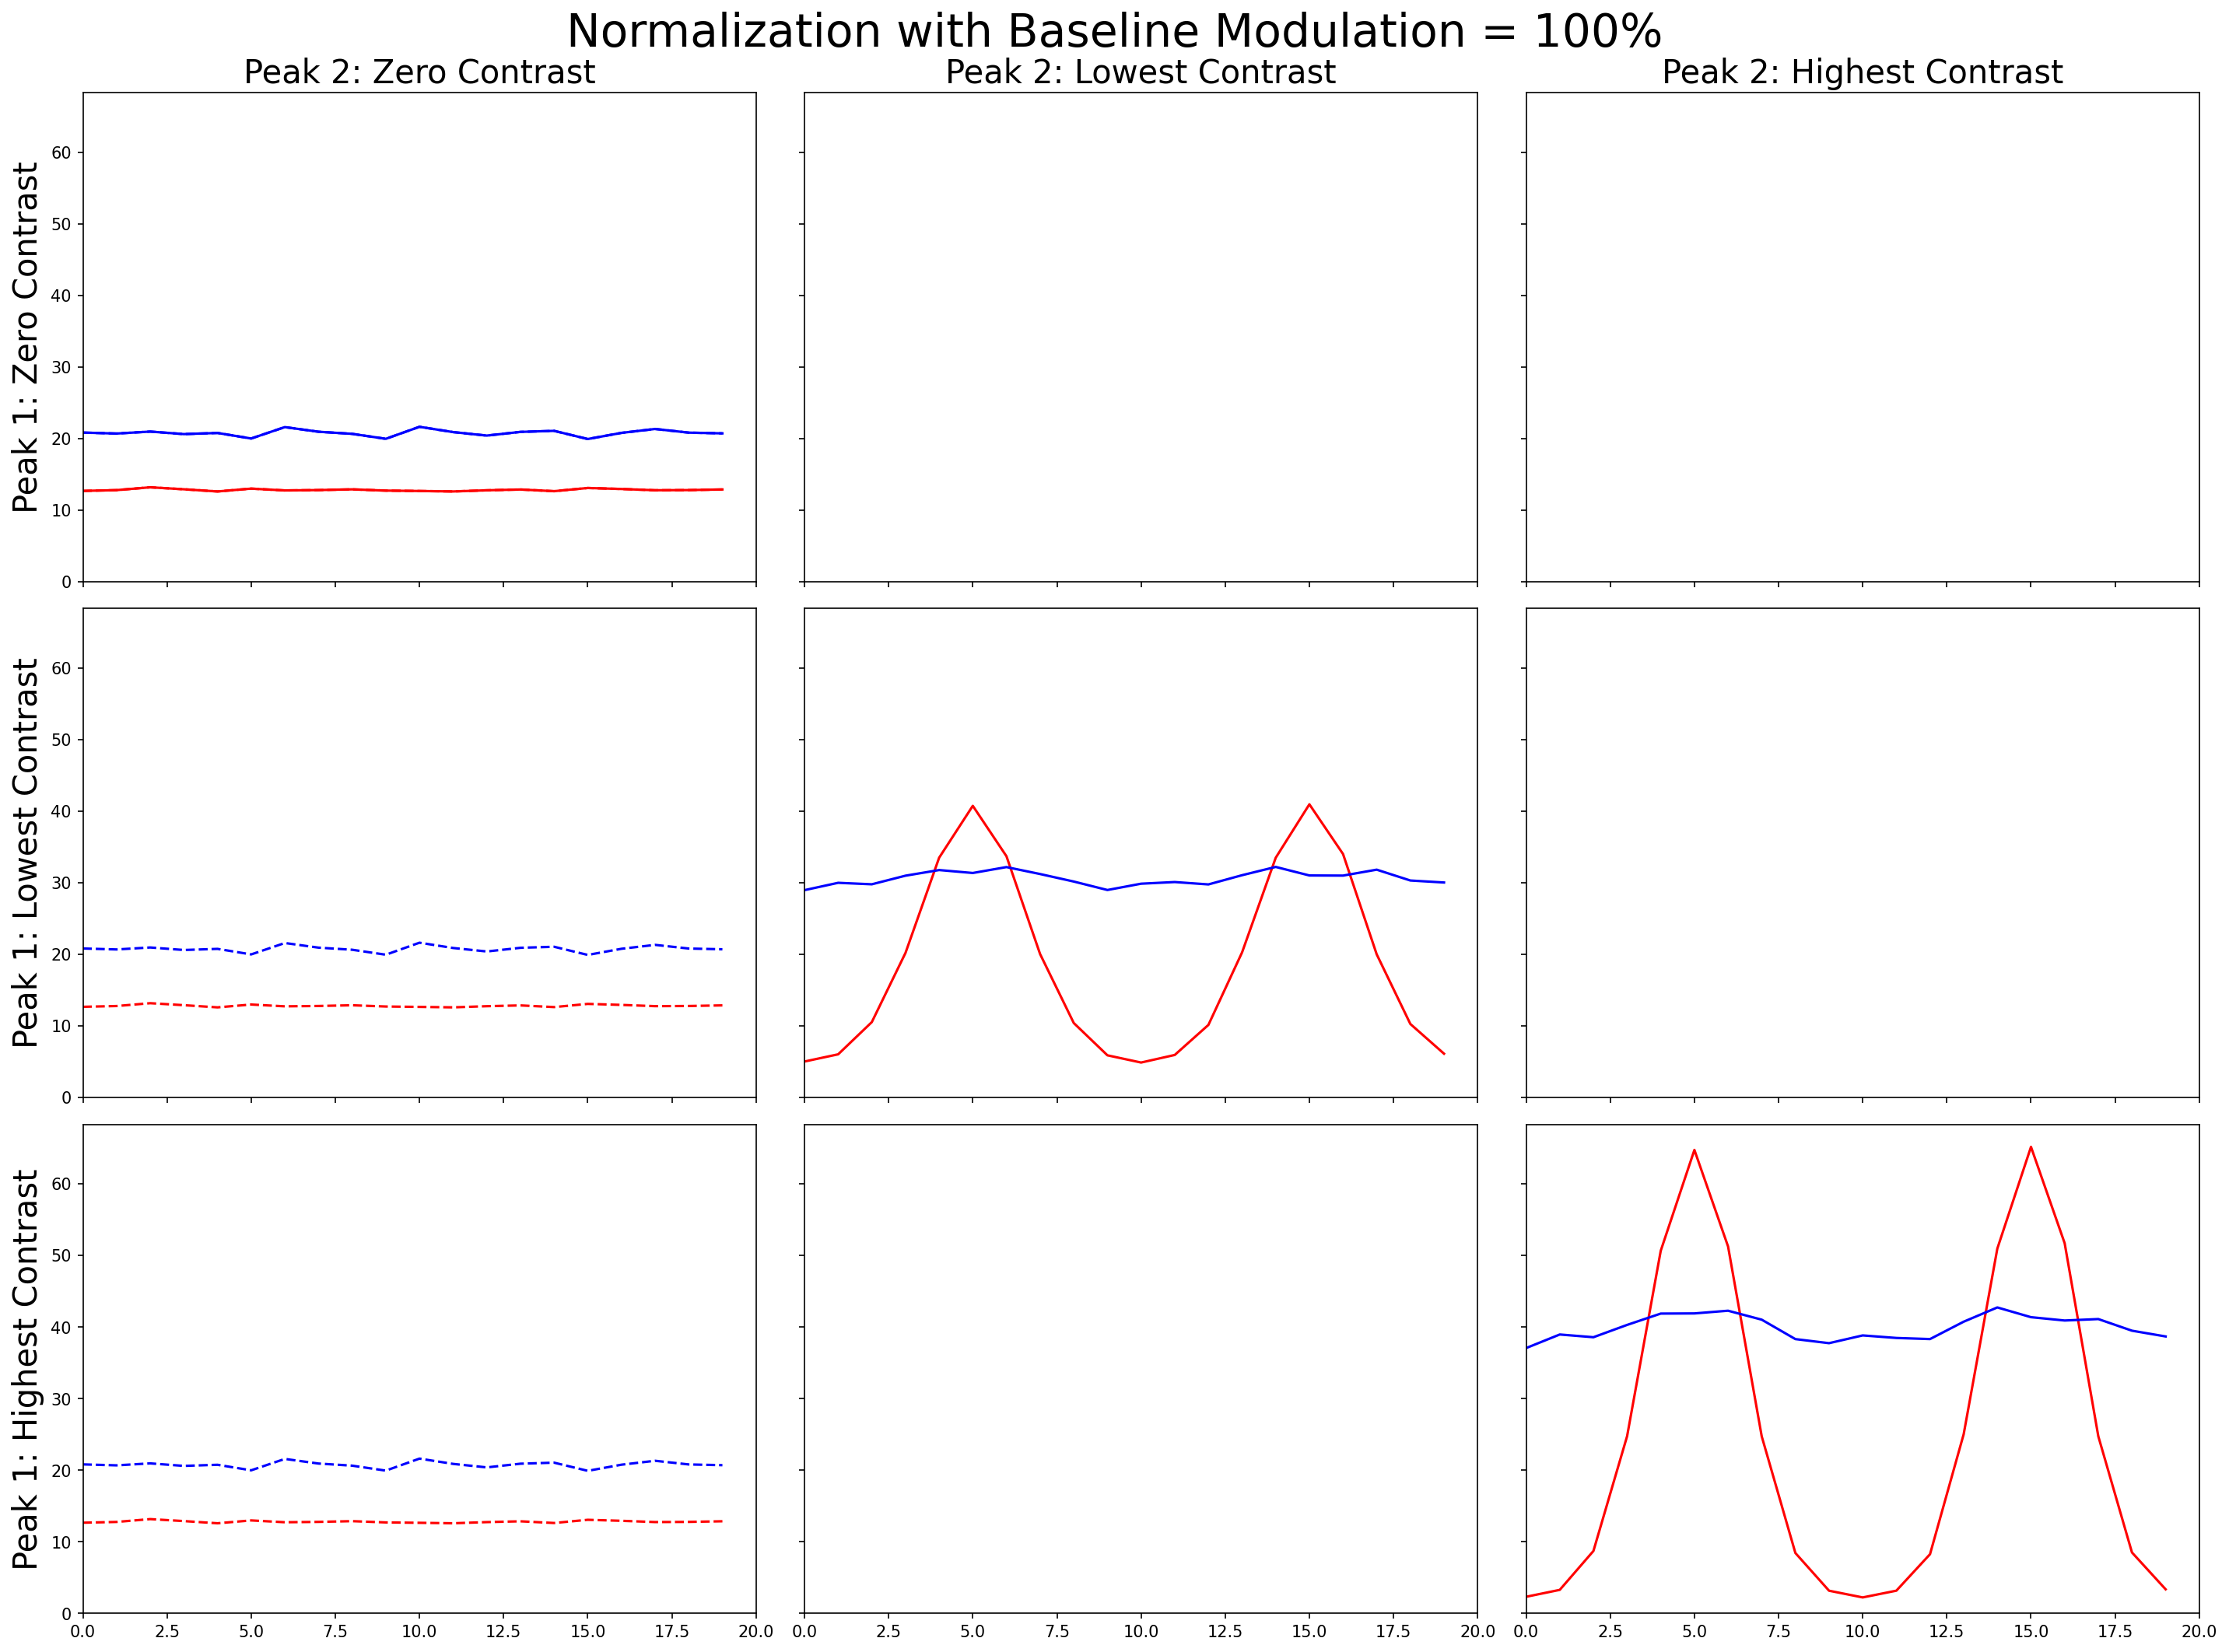

In [16]:
fig,axs = plt.subplots(3,3,figsize=(3*6.4,3*4.8),dpi=150,sharex=True,sharey=True)

b_idx = 0
o_idx = 0

for con1_idx,con1 in enumerate(cons[[0,1,-1]]):
    for con2_idx,con2 in enumerate(cons[[0,1,-1]]):
        if con2_idx > con1_idx: continue
        if con2_idx == 0:
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[o_idx,:,b_idx,[0,1,-1][con2_idx],0],Nori//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[o_idx,:,b_idx,[0,1,-1][con2_idx],0],Nori//4),'b--')
        else:
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[o_idx,:,b_idx,[0,1,-1][con1_idx],0],Nori//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[o_idx,:,b_idx,[0,1,-1][con2_idx],0],Nori*3//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[o_idx,:,b_idx,[0,1,-1][con1_idx],0],Nori//4),'b--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[o_idx,:,b_idx,[0,1,-1][con2_idx],0],Nori*3//4),'b--')
        axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[o_idx,:,b_idx,[0,1,-1][con1_idx],[0,1,-1][con2_idx]],Nori//4),'r-')
        axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[o_idx,:,b_idx,[0,1,-1][con1_idx],[0,1,-1][con2_idx]],Nori//4),'b-')
        
axs[0,0].set_xlim(0,Nori)
axs[0,0].set_ylim(0,None)
axs[0,0].set_ylabel('Peak 1: Zero Contrast',fontsize=20)
axs[1,0].set_ylabel('Peak 1: Lowest Contrast',fontsize=20)
axs[-1,0].set_ylabel('Peak 1: Highest Contrast',fontsize=20)
axs[0,0].set_title('Peak 2: Zero Contrast',fontsize=20)
axs[0,1].set_title('Peak 2: Lowest Contrast',fontsize=20)
axs[0,-1].set_title('Peak 2: Highest Contrast',fontsize=20)
fig.suptitle('Normalization with Baseline Modulation = {:d}%'.format(int(100*bases[b_idx])),fontsize=28)
fig.tight_layout()

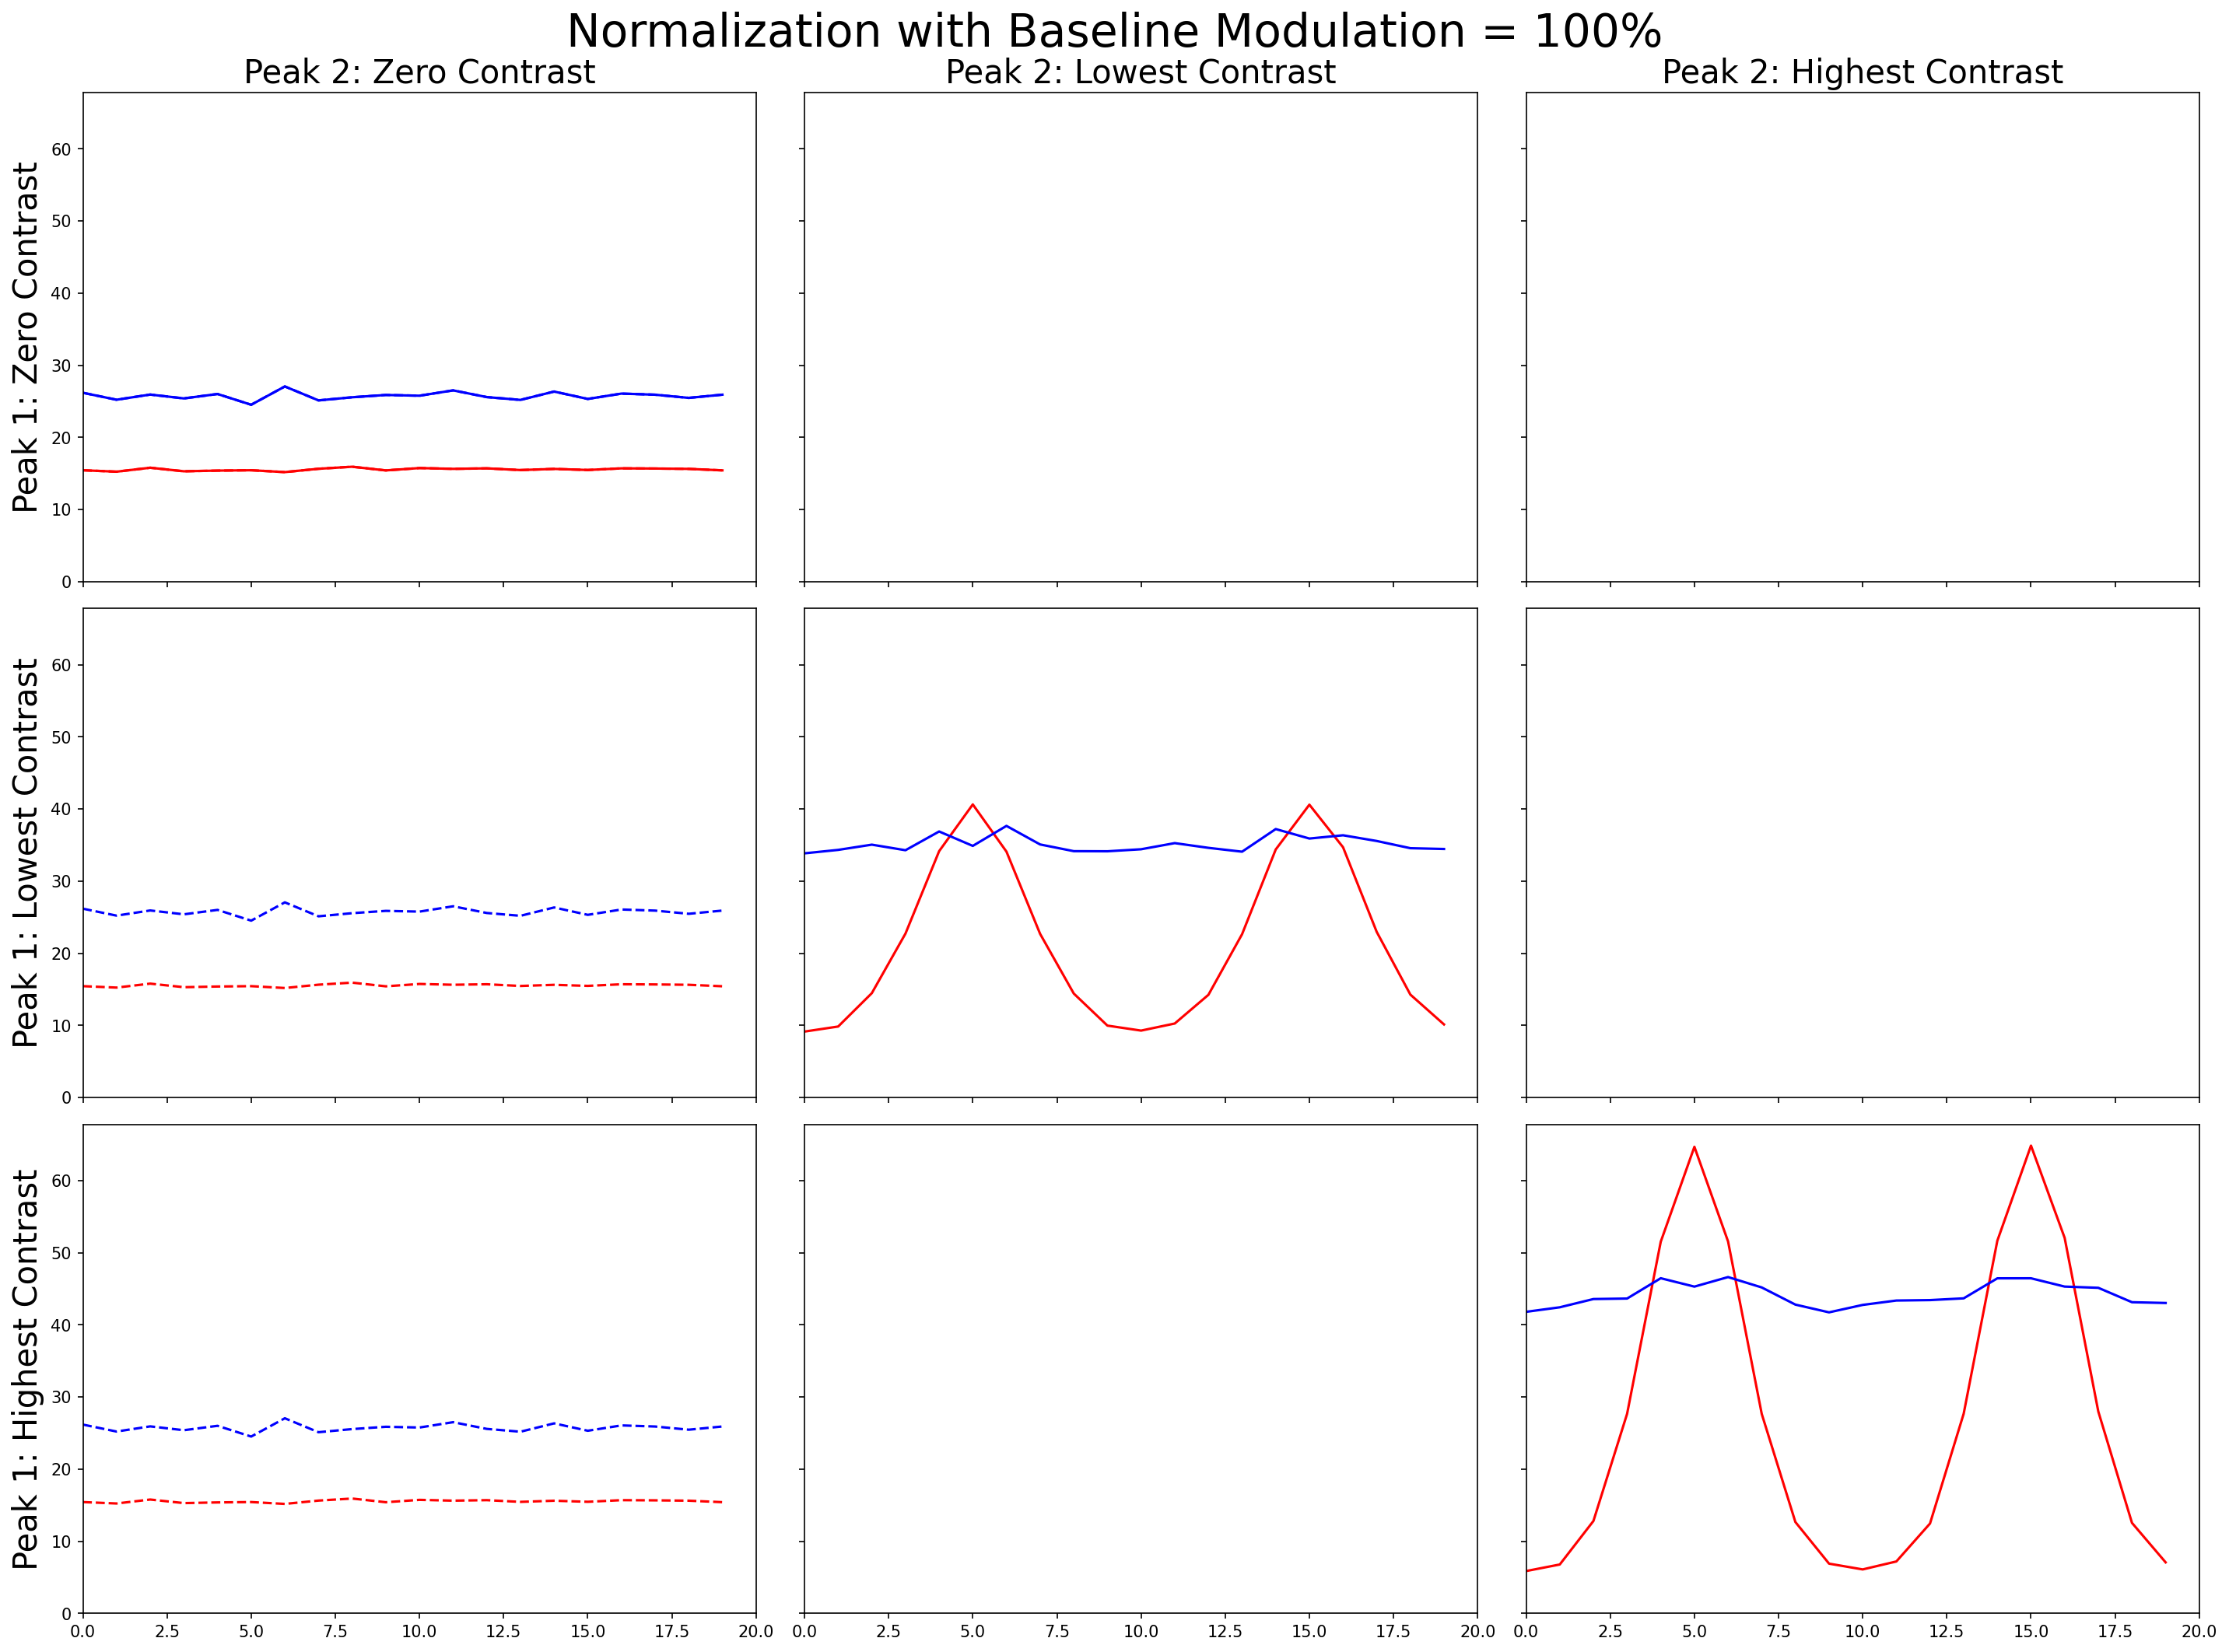

In [17]:
fig,axs = plt.subplots(3,3,figsize=(3*6.4,3*4.8),dpi=150,sharex=True,sharey=True)

b_idx = 0
o_idx = 1

for con1_idx,con1 in enumerate(cons[[0,1,-1]]):
    for con2_idx,con2 in enumerate(cons[[0,1,-1]]):
        if con2_idx > con1_idx: continue
        if con2_idx == 0:
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[o_idx,:,b_idx,[0,1,-1][con2_idx],0],Nori//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[o_idx,:,b_idx,[0,1,-1][con2_idx],0],Nori//4),'b--')
        else:
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[o_idx,:,b_idx,[0,1,-1][con1_idx],0],Nori//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[o_idx,:,b_idx,[0,1,-1][con2_idx],0],Nori*3//4),'r--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[o_idx,:,b_idx,[0,1,-1][con1_idx],0],Nori//4),'b--')
            axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[o_idx,:,b_idx,[0,1,-1][con2_idx],0],Nori*3//4),'b--')
        axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrEs[o_idx,:,b_idx,[0,1,-1][con1_idx],[0,1,-1][con2_idx]],Nori//4),'r-')
        axs[con1_idx,con2_idx].plot(np.roll(sim_norm_μrIs[o_idx,:,b_idx,[0,1,-1][con1_idx],[0,1,-1][con2_idx]],Nori//4),'b-')
        
axs[0,0].set_xlim(0,Nori)
axs[0,0].set_ylim(0,None)
axs[0,0].set_ylabel('Peak 1: Zero Contrast',fontsize=20)
axs[1,0].set_ylabel('Peak 1: Lowest Contrast',fontsize=20)
axs[-1,0].set_ylabel('Peak 1: Highest Contrast',fontsize=20)
axs[0,0].set_title('Peak 2: Zero Contrast',fontsize=20)
axs[0,1].set_title('Peak 2: Lowest Contrast',fontsize=20)
axs[0,-1].set_title('Peak 2: Highest Contrast',fontsize=20)
fig.suptitle('Normalization with Baseline Modulation = {:d}%'.format(int(100*bases[b_idx])),fontsize=28)
fig.tight_layout()

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_54009/311315833.py:17: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[0].set_xlim(0,100)


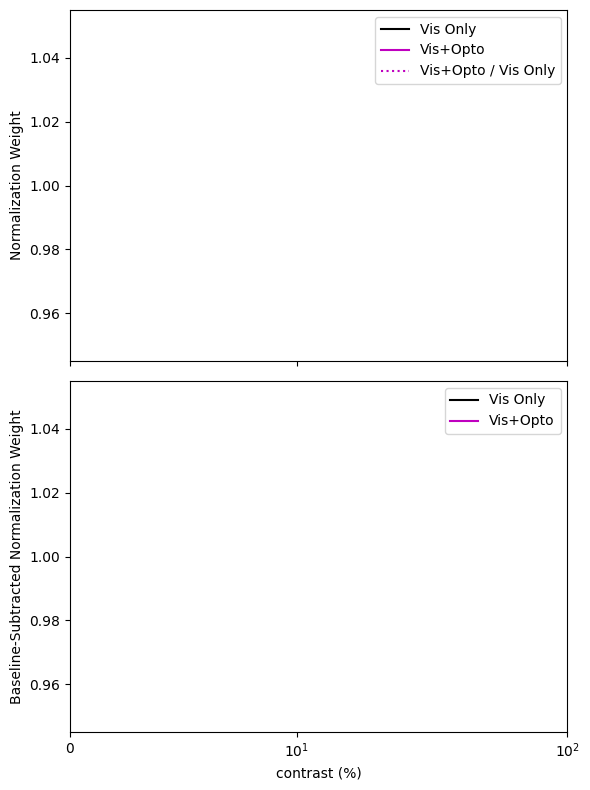

In [18]:
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]
    
fig,axs = plt.subplots(2,1,figsize=(6,8),sharex=True)

for i,opto in enumerate(np.arange(2)):
    axs[0].plot(cons,np.diag(sim_norm_μrEs[i,0,0,:,:])/sim_norm_μrEs[i,0,0,:,0],c=['k','m'][i],
                label=['Vis Only','Vis+Opto'][i])
    axs[1].plot(cons,(np.diag(sim_norm_μrEs[i,0,0,:,:])-np.mean(sim_norm_μrEs[i,:,0,0,0]))/\
                     (sim_norm_μrEs[i,0,0,:,0]-np.mean(sim_norm_μrEs[i,:,0,0,0])),c=['k','m'][i],
                label=['Vis Only','Vis+Opto'][i])
axs[0].plot(cons[1:],sim_norm_μrEs[1,0,0,1:,0]/sim_norm_μrEs[0,0,0,1:,0],c=['k','m'][i],ls=':',
            label='Vis+Opto / Vis Only')
axs[0].legend()
axs[1].legend()
axs[0].set_xscale('symlog',linthresh=12)
axs[0].set_xlim(0,100)
axs[1].set_xlabel('contrast (%)')
axs[0].set_ylabel('Normalization Weight')
axs[1].set_ylabel('Baseline-Subtracted Normalization Weight')

fig.tight_layout()
fig.savefig('./../plots/opto_norm.pdf')

# Investigate Ahmadian, Rubin, & Miller Model with Baselines

In [375]:
ssn = srp.SSN()

J = np.array([
    [ 2.5,-1.3],
    [ 2.4,-1.0]
])
g = np.array([1,1])

oris = np.arange(180)
oris[oris > 90] = 180 - oris[oris > 90]
doris = np.abs(np.arange(180)[:,None] - np.arange(180)[None,:])
doris[doris > 90] = 180 - doris[doris > 90]
Jori = base_net.apply_kernel(doris,32,180,dx=np.pi/180,kernel='nonnormwrapgauss')
# Jori = base_net.apply_kernel(doris,32,180,dx=1/(np.sqrt(2*np.pi)*32),kernel='nonnormwrapgauss')
gori = base_net.apply_kernel(oris,30,180,kernel='nonnormwrapgauss')

W = np.kron(J,Jori)
g1 = np.kron(g,gori)
g12 = np.kron(g,gori) + np.kron(g,np.roll(gori,90))

tau = np.kron(np.array([ssn.tE,ssn.tI]),np.ones(180))

def drdt(t,r,W,h):
    u = W@r + h
    return (-r+ssn.phiE(u))/tau

In [331]:
cs = np.linspace(0,100,51)
bs = np.linspace(0,50,3)
r1s = np.zeros((len(bs),len(cs),180*2))
r12s = np.zeros((len(bs),len(cs),180*2))

for b_idx,b in enumerate(bs):
    for c_idx,c in enumerate(cs):
        sol = scipy.integrate.solve_ivp(drdt,(0,1),b+c*g1,args=(W,b+c*g1,))
        r1s[b_idx,c_idx] = sol.y[:,-1]
        
        sol = scipy.integrate.solve_ivp(drdt,(0,1),b+c*g12,args=(W,b+c*g12,))
        r12s[b_idx,c_idx] = sol.y[:,-1]

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_6565/3286581202.py:9: RuntimeWarning: invalid value encountered in divide
  axs[1,b_idx].plot(cs,r12s[b_idx,:,  0]/(r1s[b_idx,:,  0]+r1s[b_idx,:, 90]),'r-')
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_6565/3286581202.py:10: RuntimeWarning: invalid value encountered in divide
  axs[1,b_idx].plot(cs,r12s[b_idx,:,180]/(r1s[b_idx,:,180]+r1s[b_idx,:,270]),'b-')


Text(0, 0.5, 'Normalization Weights')

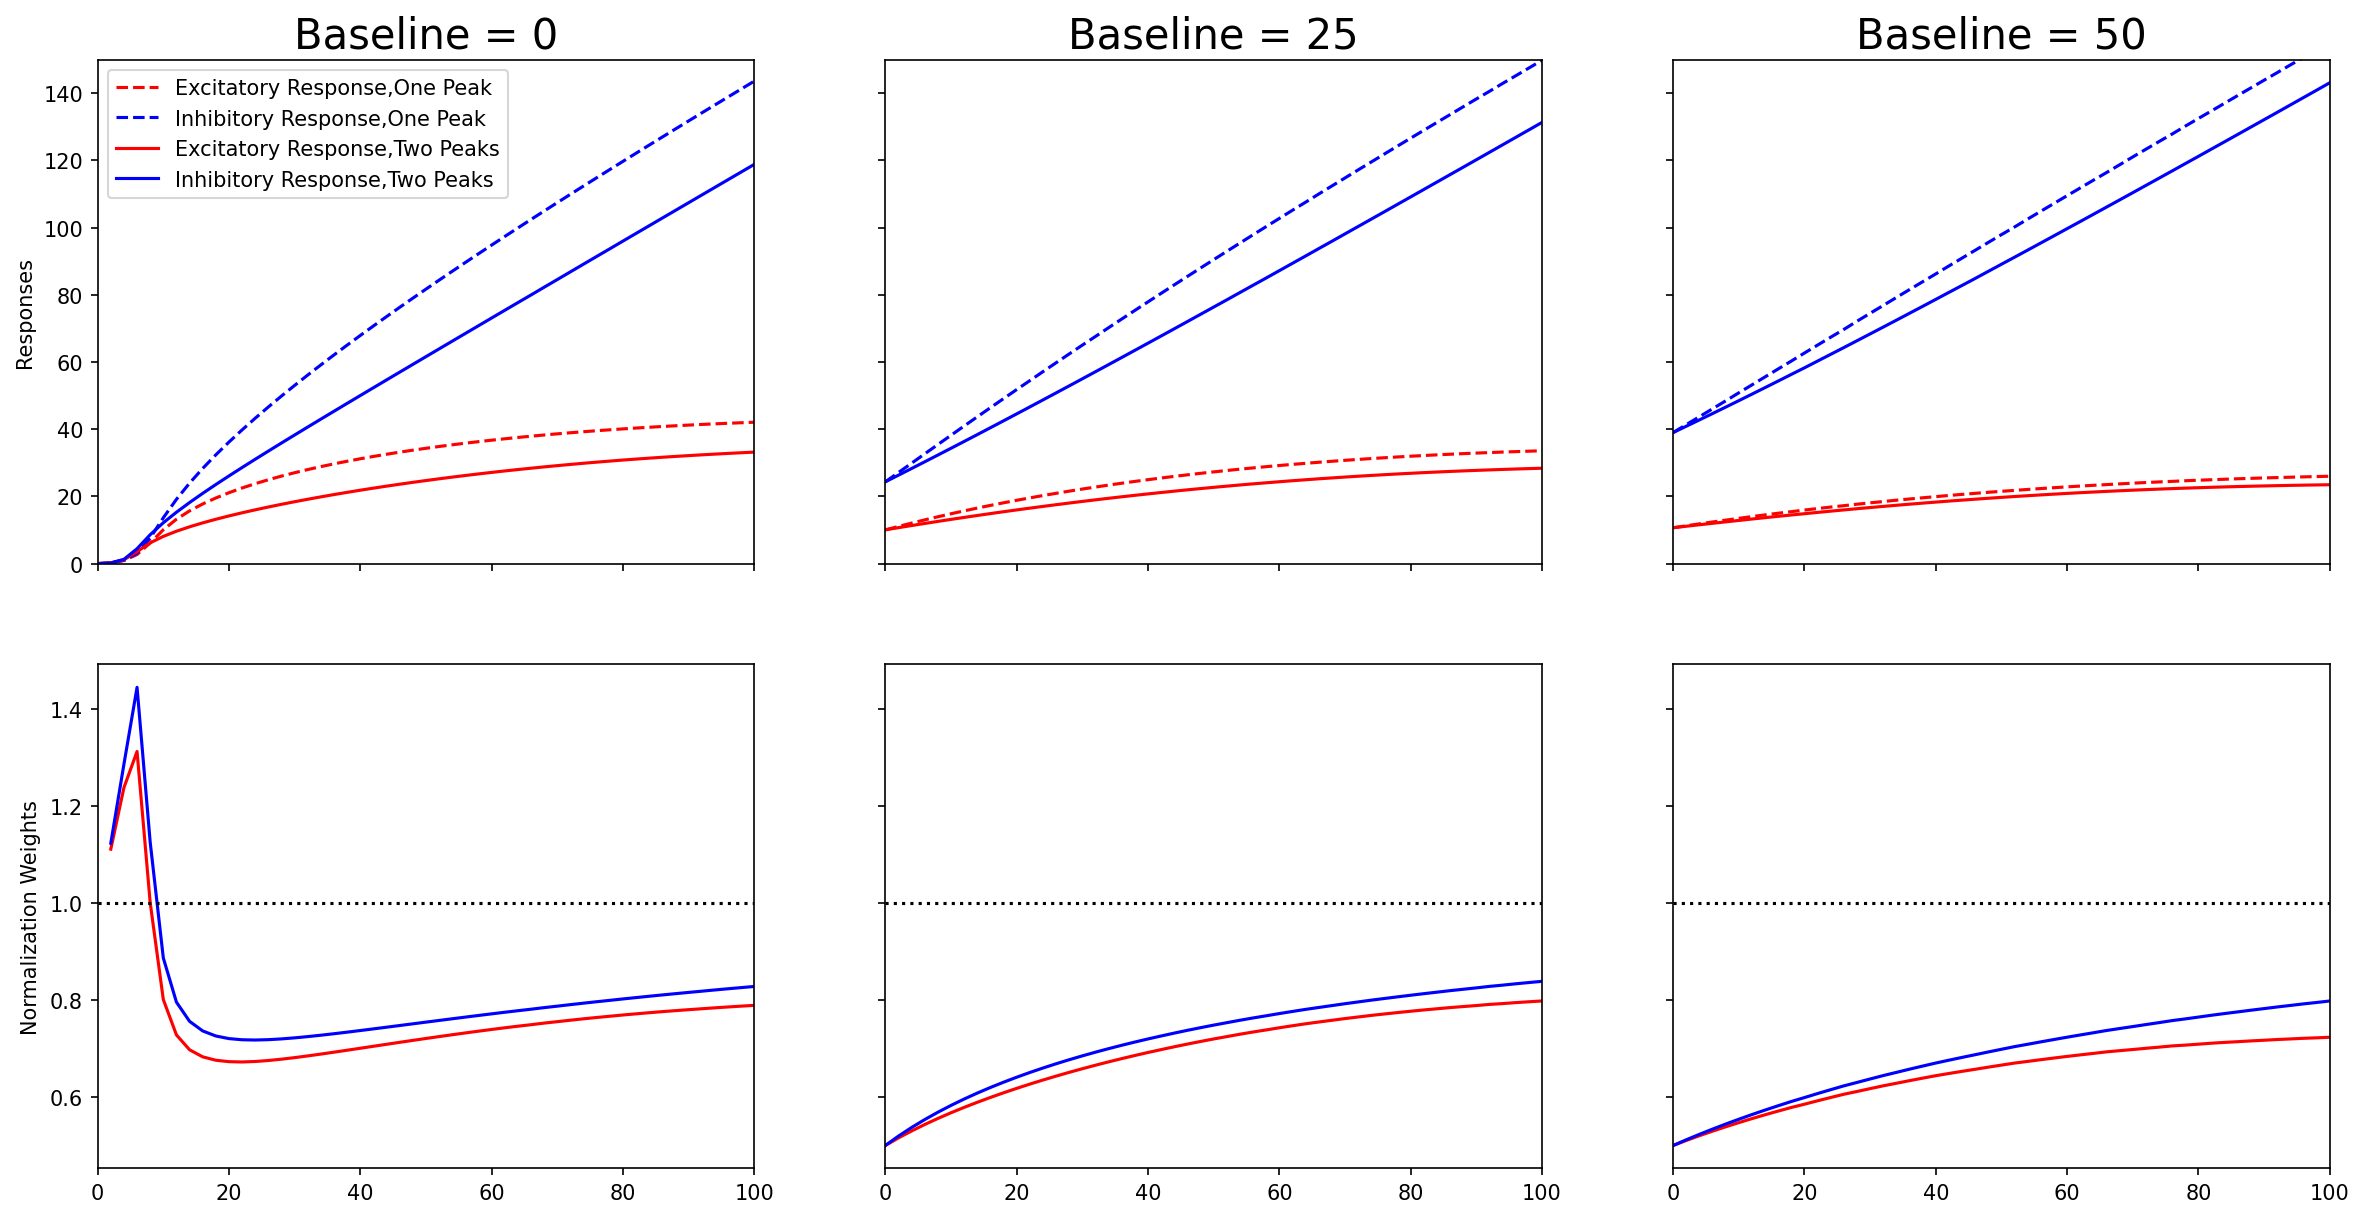

In [332]:
fig,axs = plt.subplots(2,3,figsize=(3*6.4,2*4.8),dpi=150,sharex=True,sharey='row')

for b_idx,b in enumerate(bs):
    axs[0,b_idx].plot(cs,r1s[b_idx,:,  0],'r--',label='Excitatory Response,One Peak')
    axs[0,b_idx].plot(cs,r1s[b_idx,:,180],'b--',label='Inhibitory Response,One Peak')
    axs[0,b_idx].plot(cs,r12s[b_idx,:,  0],'r-',label='Excitatory Response,Two Peaks')
    axs[0,b_idx].plot(cs,r12s[b_idx,:,180],'b-',label='Inhibitory Response,Two Peaks')

    axs[1,b_idx].plot(cs,r12s[b_idx,:,  0]/(r1s[b_idx,:,  0]+r1s[b_idx,:, 90]),'r-')
    axs[1,b_idx].plot(cs,r12s[b_idx,:,180]/(r1s[b_idx,:,180]+r1s[b_idx,:,270]),'b-')

    axs[0,b_idx].set_xlim(0,100)
    axs[0,b_idx].set_ylim(0,150)
    axs[0,b_idx].set_title('Baseline = {:d}'.format(int(b)),fontsize=20)
    axs[1,b_idx].axhline(1,c='k',ls=':')
    
axs[0,0].set_ylabel('Responses')
axs[0,0].legend()
axs[1,0].set_ylabel('Normalization Weights')

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_6565/153667323.py:9: RuntimeWarning: invalid value encountered in divide
  axs[1,b_idx].plot(cs,r12s[b_idx,:,  0]/(r1s[b_idx,:,  0]),'r-')
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_6565/153667323.py:10: RuntimeWarning: invalid value encountered in divide
  axs[1,b_idx].plot(cs,r12s[b_idx,:,180]/(r1s[b_idx,:,180]),'b-')


Text(0, 0.5, 'Normalization Weights')

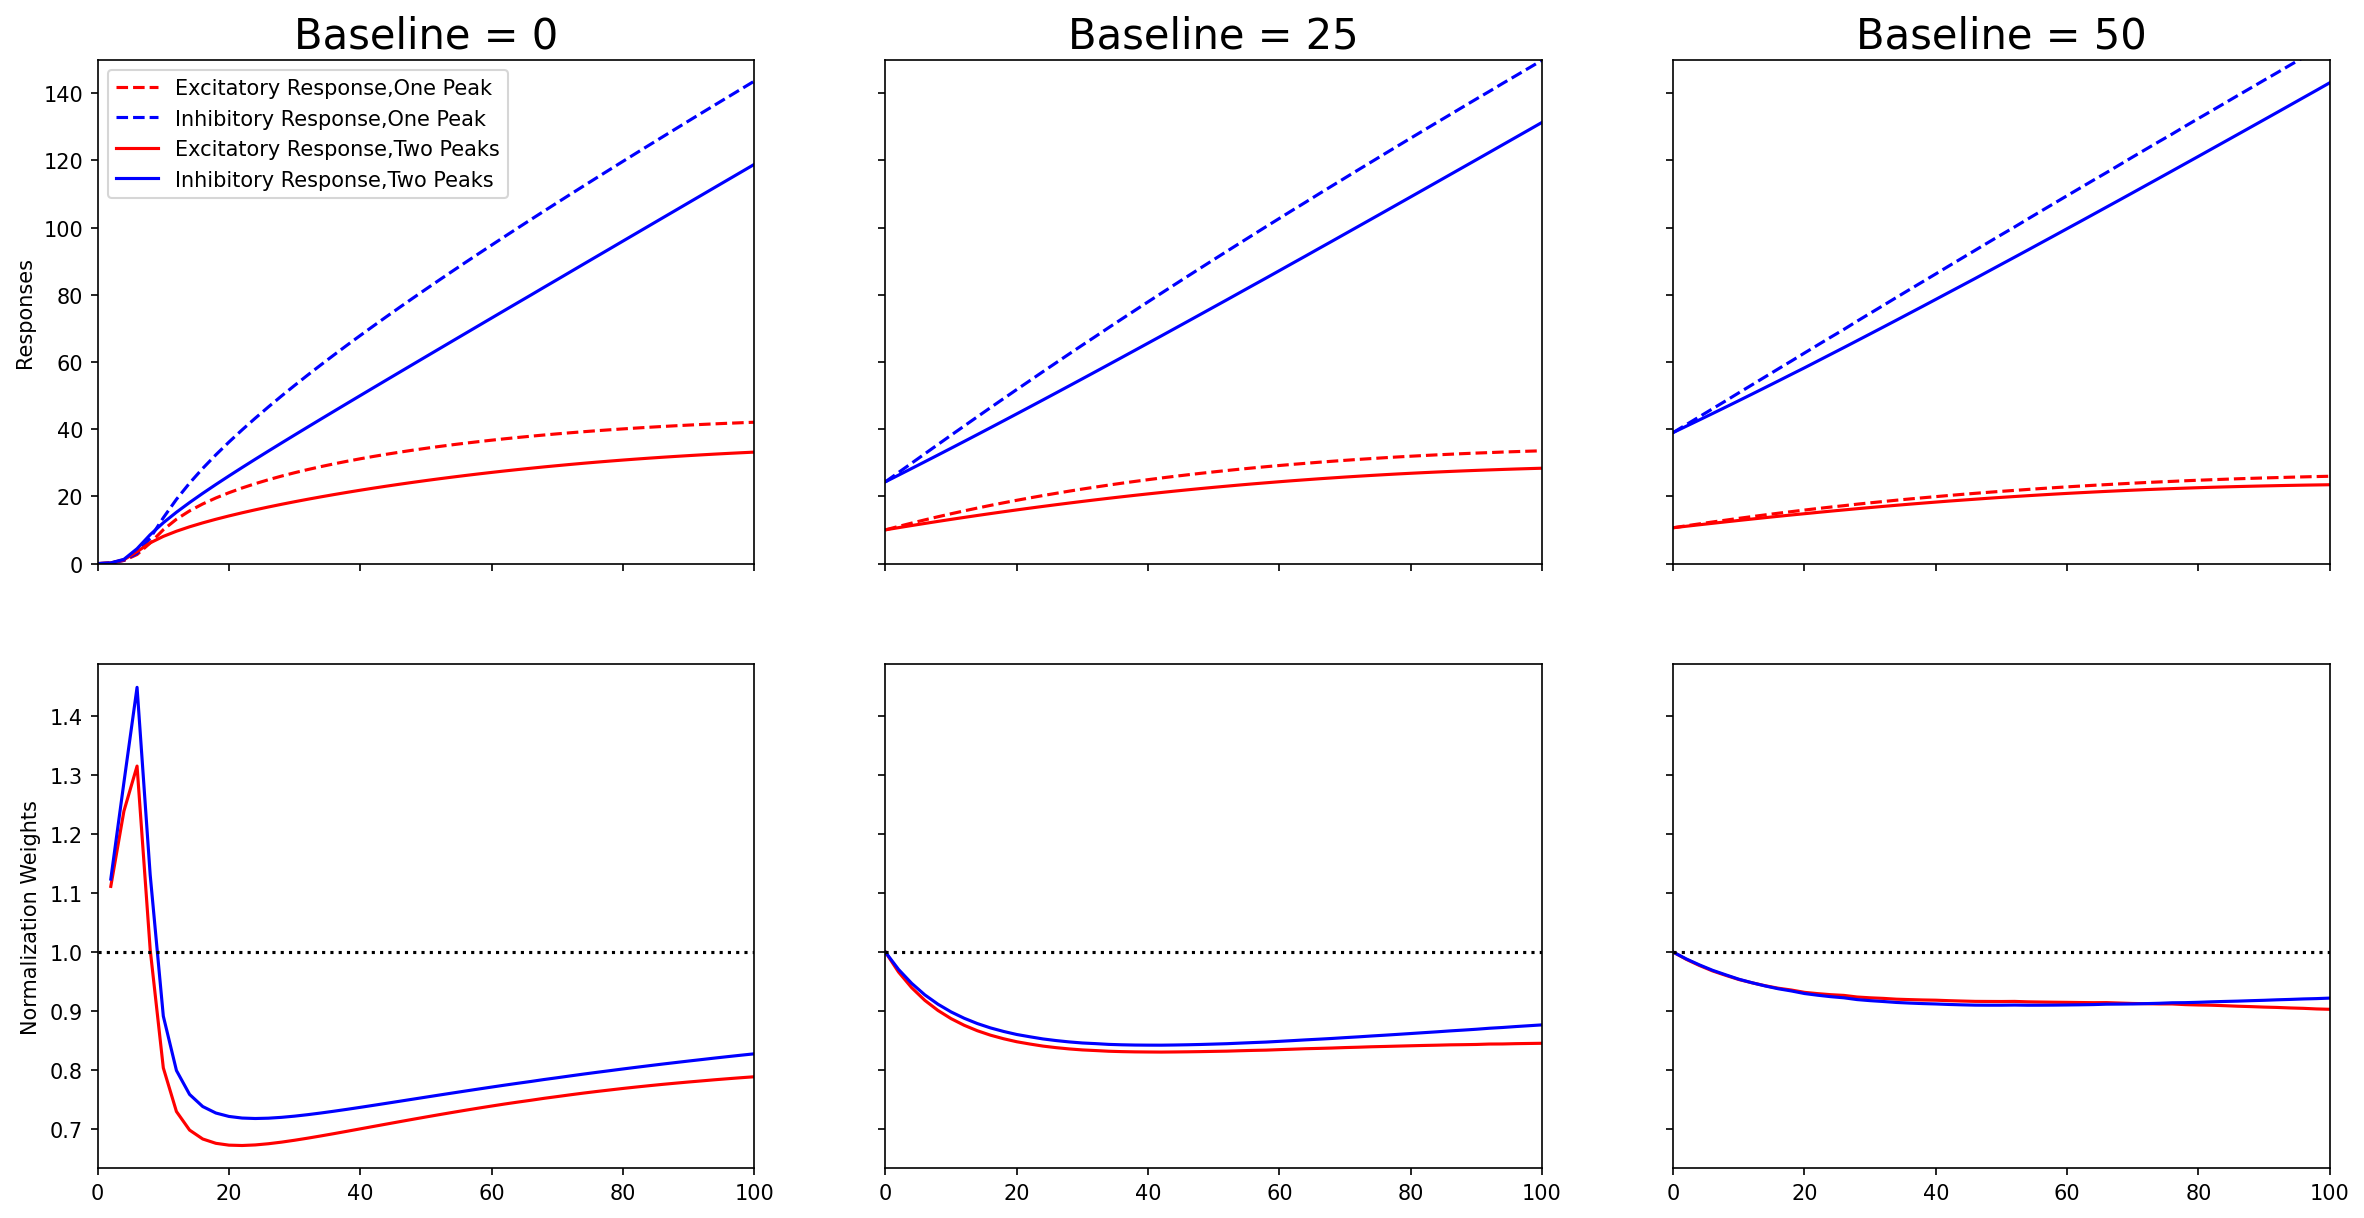

In [334]:
fig,axs = plt.subplots(2,3,figsize=(3*6.4,2*4.8),dpi=150,sharex=True,sharey='row')

for b_idx,b in enumerate(bs):
    axs[0,b_idx].plot(cs,r1s[b_idx,:,  0],'r--',label='Excitatory Response,One Peak')
    axs[0,b_idx].plot(cs,r1s[b_idx,:,180],'b--',label='Inhibitory Response,One Peak')
    axs[0,b_idx].plot(cs,r12s[b_idx,:,  0],'r-',label='Excitatory Response,Two Peaks')
    axs[0,b_idx].plot(cs,r12s[b_idx,:,180],'b-',label='Inhibitory Response,Two Peaks')

    axs[1,b_idx].plot(cs,r12s[b_idx,:,  0]/(r1s[b_idx,:,  0]),'r-')
    axs[1,b_idx].plot(cs,r12s[b_idx,:,180]/(r1s[b_idx,:,180]),'b-')

    axs[0,b_idx].set_xlim(0,100)
    axs[0,b_idx].set_ylim(0,150)
    axs[0,b_idx].set_title('Baseline = {:d}'.format(int(b)),fontsize=20)
    axs[1,b_idx].axhline(1,c='k',ls=':')
    
axs[0,0].set_ylabel('Responses')
axs[0,0].legend()
axs[1,0].set_ylabel('Normalization Weights')

(0.0, 150.74837236338053)

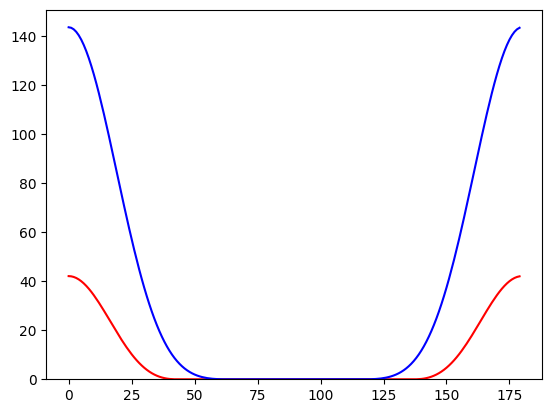

In [340]:
plt.plot(r1s[0,-1,:180],'r-')
plt.plot(r1s[0,-1,180:],'b-')
plt.ylim(0,None)

(0.0, 162.92068140168914)

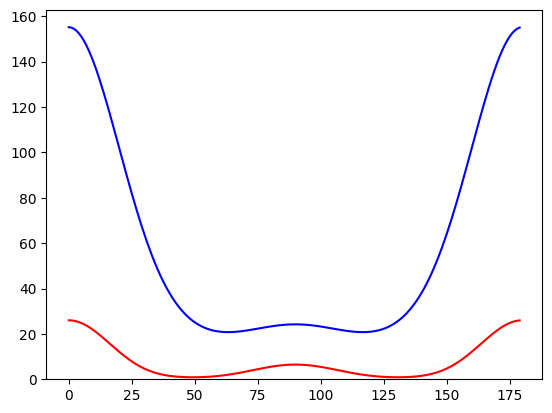

In [339]:
plt.plot(r1s[-1,-1,:180],'r-')
plt.plot(r1s[-1,-1,180:],'b-')
plt.ylim(0,None)

In [330]:
print(np.dot(Jori[0,:],gori**2))
print(np.dot(Jori[0,:],(gori+np.roll(gori,90))**2))

0.7735760828880975
1.037654326516526


In [352]:
ssn = srp.SSN()

Js = np.array([
    [[ 2.5,-1.3],
     [ 2.4,-1.0]],
    [[ 2.5,-1.3],
     [ 4.7,-1.0]],
    [[ 2.5,-1.3],
     [ 4.7,-2.2]],
    [[ 0.8,-1.3],
     [ 3.6,-5.0]],
])
g = np.array([1,1])

oris = np.arange(180)
oris[oris > 90] = 180 - oris[oris > 90]
doris = np.abs(np.arange(180)[:,None] - np.arange(180)[None,:])
doris[doris > 90] = 180 - doris[doris > 90]
Jori = base_net.apply_kernel(doris,32,180,dx=np.pi/180,kernel='nonnormwrapgauss')
gori = base_net.apply_kernel(oris,30,180,kernel='nonnormwrapgauss')

Ws = np.array([np.kron(Js[i],Jori) for i in range(4)])
g1 = np.kron(g,gori)
g12 = np.kron(g,gori) + np.kron(g,np.roll(gori,90))

tau = np.kron(np.array([ssn.tE,ssn.tI]),np.ones(180))

def drdt(t,r,W,h):
    u = W@r + h
    return (-r+ssn.phiE(u))/tau

In [356]:
cs = np.linspace(0,500,51)
bs = np.linspace(0,50,3)
r1s = np.zeros((4,len(bs),len(cs),180*2))
r12s = np.zeros((4,len(bs),len(cs),180*2))

for i in range(4):
    for b_idx,b in enumerate(bs):
        for c_idx,c in enumerate(cs):
            sol = scipy.integrate.solve_ivp(drdt,(0,1),b+c*g1,args=(Ws[i],b+c*g1,))
            r1s[i,b_idx,c_idx] = sol.y[:,-1]
            
            sol = scipy.integrate.solve_ivp(drdt,(0,1),b+c*g12,args=(Ws[i],b+c*g12,))
            r12s[i,b_idx,c_idx] = sol.y[:,-1]

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_6565/663812936.py:19: RuntimeWarning: invalid value encountered in divide
  axs[3*i+2,b_idx].plot(cs,r12s[i,b_idx,:,  0]/(r1s[i,b_idx,:,  0]+r1s[i,0,:, 90]),'r-')#+r1s[i,b_idx,:, 90]),'r-')
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_6565/663812936.py:20: RuntimeWarning: invalid value encountered in divide
  axs[3*i+2,b_idx].plot(cs,r12s[i,b_idx,:,180]/(r1s[i,b_idx,:,180]+r1s[i,0,:,270]),'b-')#+r1s[i,b_idx,:,270]),'b-')


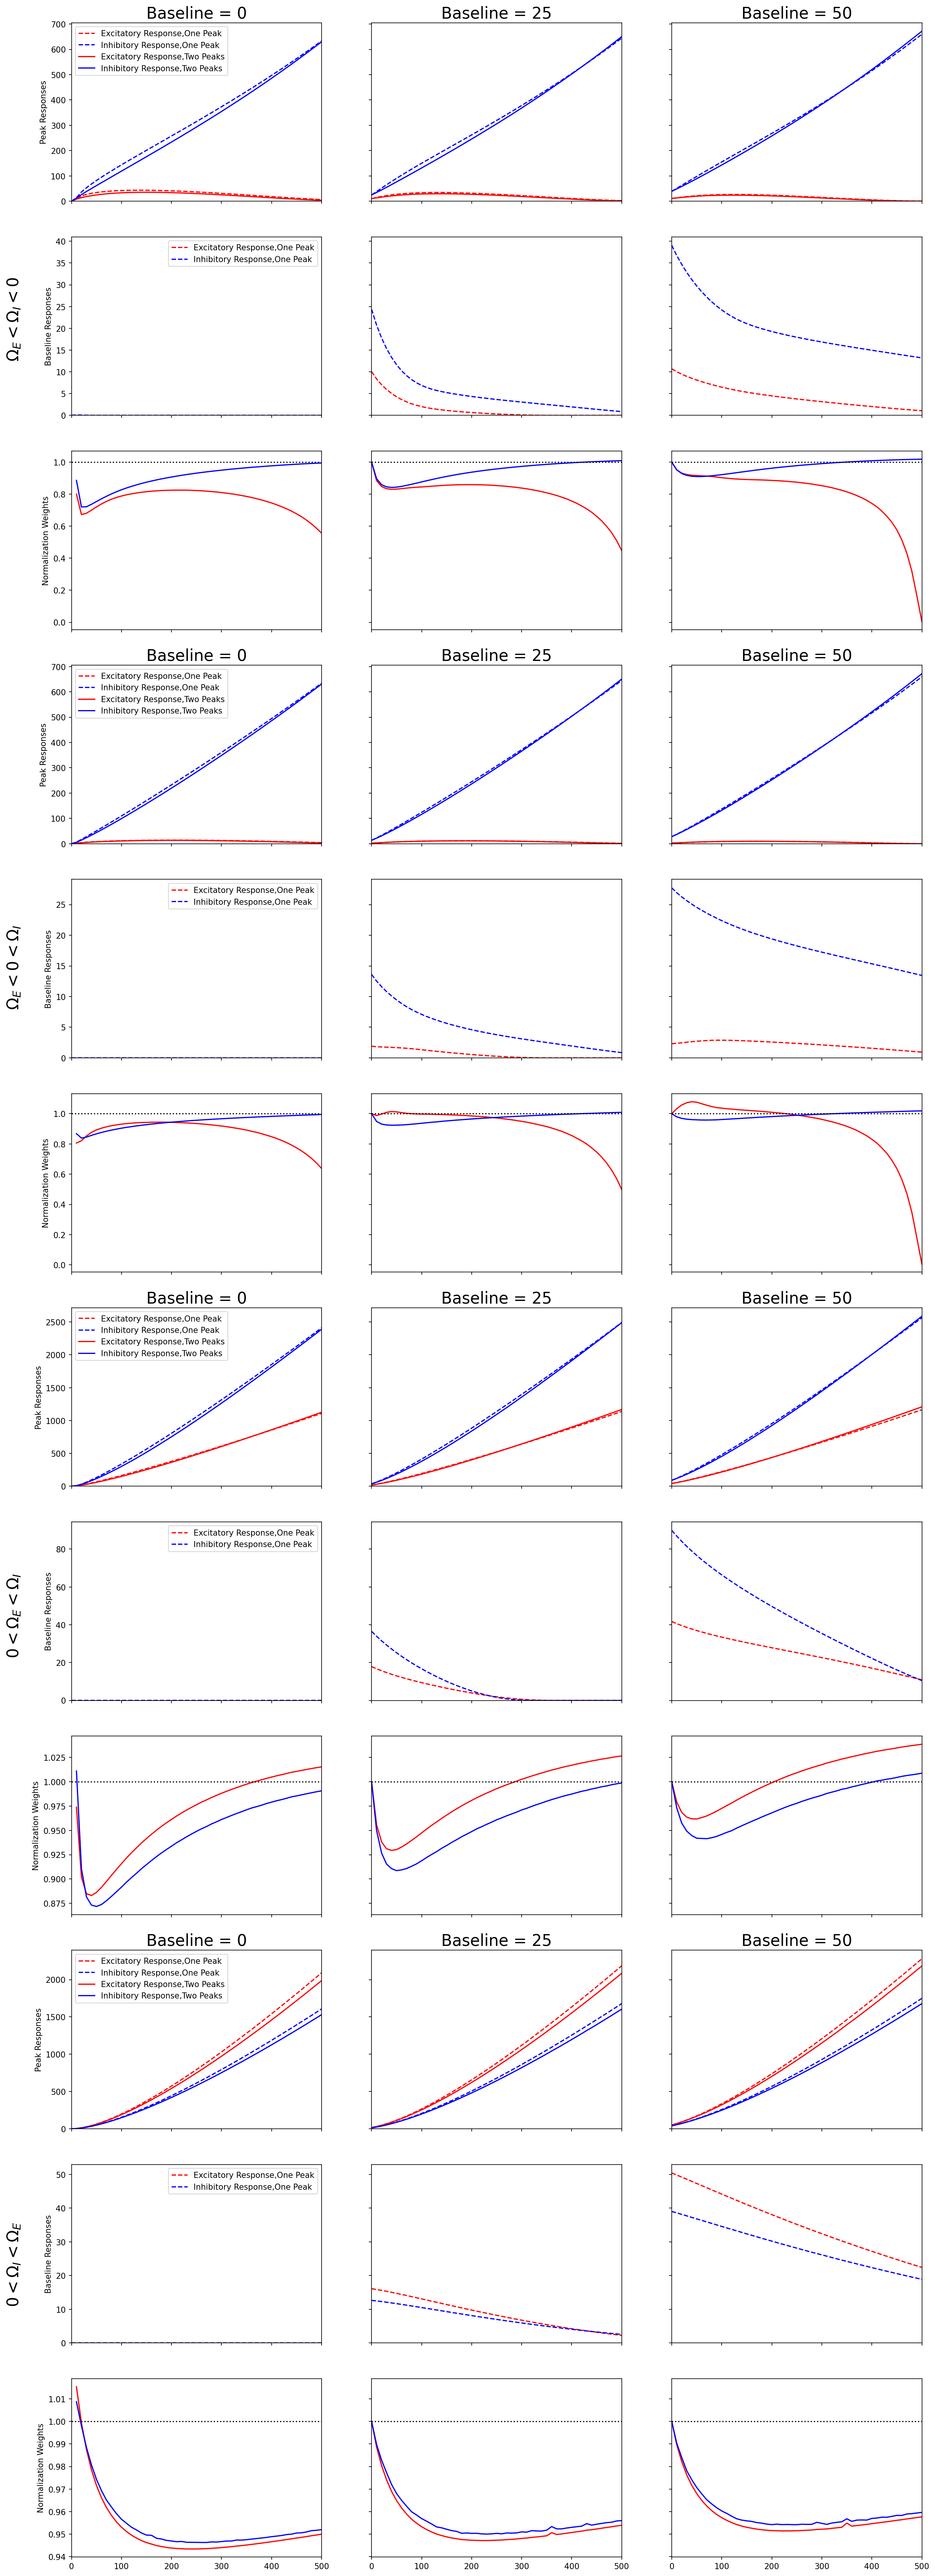

In [395]:
fig,axs = plt.subplots(12,3,figsize=(3*6.4,12*4.8),dpi=150,sharex=True,sharey='row')

for i in range(4):
    for b_idx,b in enumerate(bs):
        axs[3*i+0,b_idx].plot(cs,r1s[i,b_idx,:,  0],'r--',label='Excitatory Response,One Peak')
        axs[3*i+0,b_idx].plot(cs,r1s[i,b_idx,:,180],'b--',label='Inhibitory Response,One Peak')
        axs[3*i+0,b_idx].plot(cs,r12s[i,b_idx,:,  0],'r-',label='Excitatory Response,Two Peaks')
        axs[3*i+0,b_idx].plot(cs,r12s[i,b_idx,:,180],'b-',label='Inhibitory Response,Two Peaks')
        
        axs[3*i+1,b_idx].plot(cs,r1s[i,b_idx,:, 90],'r--',label='Excitatory Response,One Peak')
        axs[3*i+1,b_idx].plot(cs,r1s[i,b_idx,:,270],'b--',label='Inhibitory Response,One Peak')
        # axs[3*i+1,b_idx].plot(cs,r12s[i,b_idx,:, 90],'r-',label='Excitatory Response,Two Peaks')
        # axs[3*i+1,b_idx].plot(cs,r12s[i,b_idx,:,270],'b-',label='Inhibitory Response,Two Peaks')

        # axs[3*i+2,b_idx].plot(cs,r12s[i,b_idx,:,  0]/(r1s[i,b_idx,:,  0]),'r-')#+r1s[i,b_idx,:, 90]),'r-')
        # axs[3*i+2,b_idx].plot(cs,r12s[i,b_idx,:,180]/(r1s[i,b_idx,:,180]),'b-')#+r1s[i,b_idx,:,270]),'b-')
        # axs[3*i+2,b_idx].plot(cs,r12s[i,b_idx,:,  0]/(r1s[i,b_idx,0,  0]+r1s[i,0,:,  0]+r1s[i,0,:, 90]),'r-')#+r1s[i,b_idx,:, 90]),'r-')
        # axs[3*i+2,b_idx].plot(cs,r12s[i,b_idx,:,180]/(r1s[i,b_idx,0,180]+r1s[i,0,:,180]+r1s[i,0,:,270]),'b-')#+r1s[i,b_idx,:,270]),'b-')
        axs[3*i+2,b_idx].plot(cs,r12s[i,b_idx,:,  0]/(r1s[i,b_idx,:,  0]+r1s[i,0,:, 90]),'r-')#+r1s[i,b_idx,:, 90]),'r-')
        axs[3*i+2,b_idx].plot(cs,r12s[i,b_idx,:,180]/(r1s[i,b_idx,:,180]+r1s[i,0,:,270]),'b-')#+r1s[i,b_idx,:,270]),'b-')

        axs[3*i+0,b_idx].set_xlim(0,500)
        # axs[3*i+0,b_idx].set_ylim(0,None)
        axs[3*i+0,b_idx].set_title('Baseline = {:d}'.format(int(b)),fontsize=20)
        # axs[3*i+1,b_idx].set_ylim(0,None)
        axs[3*i+2,b_idx].axhline(1,c='k',ls=':')
        
    axs[3*i+0,0].set_ylabel('Peak Responses')
    axs[3*i+0,0].legend()
    axs[3*i+0,-1].set_ylim(0,None)
    axs[3*i+1,0].set_ylabel('Baseline Responses')
    axs[3*i+1,0].legend()
    axs[3*i+1,-1].set_ylim(0,None)
    axs[3*i+2,0].set_ylabel('Normalization Weights')
    
    fig.text(0.08,1-i*0.197-0.21,[r'$\Omega_E<\Omega_I<0$',
                            r'$\Omega_E<0<\Omega_I$',
                            r'$0<\Omega_E<\Omega_I$',
                            r'$0<\Omega_I<\Omega_E$'][i],fontsize=20,ha='right',va='center',rotation='vertical')

In [391]:
r1s[0,-1,:, 90]

array([10.68387585, 10.01815456,  9.45528039,  8.95770911,  8.51233004,
        8.10956191,  7.73647538,  7.38982141,  7.06564299,  6.76245506,
        6.47917578,  6.21376113,  5.96630803,  5.735845  ,  5.52196708,
        5.32268169,  5.13538244,  4.95882825,  4.79054906,  4.6295321 ,
        4.47477881,  4.32519065,  4.18115027,  4.04055541,  3.90436723,
        3.77071736,  3.64062498,  3.5127835 ,  3.38699346,  3.26434929,
        3.1426837 ,  3.0233474 ,  2.90604465,  2.7903123 ,  2.67601536,
        2.56306854,  2.45154604,  2.34173276,  2.23323075,  2.12633557,
        2.02074138,  1.9162692 ,  1.81436948,  1.71351815,  1.61430616,
        1.51693585,  1.42128793,  1.32793979,  1.23652078,  1.14719188,
        1.06046307])